# Module 3 - Supervised Learning

## Imports

In [1]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm

## Helper Functions

In [2]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, matthews_corrcoef

def performance_metrics(y, y_prediction):
    confusion = confusion_matrix(y, y_prediction)
    cmap = sb.light_palette("green", as_cmap=True)
    confusion_plot = pd.DataFrame(confusion)
    confusion_plot = confusion_plot.style.background_gradient(cmap=cmap)
    
    display(confusion_plot)
    print('%38s: %.4f' % ('Accuracy Score', accuracy_score(y, y_prediction, normalize=True))) #best performance is 1 with normalize == True

    print('%38s: %.4f' % ('F1-Score', f1_score(y, y_prediction, average='macro'))) # F1 = 2 * (precision * recall) / (precision + recall)
    print('%38s: %.4f' % ('Matthews Correlation Coefficient (MCC)', matthews_corrcoef(y, y_prediction))) #+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction
    print('%38s: %.4f' % ('Area Under the Curve (AUC)', matthews_corrcoef(y, y_prediction)))

In [3]:
from sklearn.model_selection import KFold

def cross_validation_KFold(clf, X_train, y_train, title, number_splits=10, plot=True):
    kf = KFold(n_splits=number_splits, shuffle=False)
    
    accuracy = []
    for train_index, test_index in kf.split(X_train):
        clf = clf.fit(X_train[train_index, :], y_train[train_index])
        y_train_prediction = clf.predict(X_train[train_index, :])
        
        accuracy.append(accuracy_score(y_train[train_index], y_train_prediction, normalize=True))
        print('%s: %.4f' % ('Accuracy Score', accuracy[-1]))
        
    if plot:
        ax = sb.scatterplot(x=range(1, len(accuracy) + 1), y=accuracy, palette="Blues_d")
        ax.set(xlabel='Iteration', ylabel='Accuracy', title='K-Fold ' + title)
        ax.figure.savefig('Module3/KFold_' + title + '.png')

In [4]:
from sklearn.model_selection import ShuffleSplit

def cross_validation_ShuffleSplit(clf, X_train, y_train, title, number_splits=10, plot=True):
    ss = ShuffleSplit(n_splits=number_splits, test_size=0.25)
    
    accuracy = []
    for train_index, test_index in ss.split(X_train):
        clf = clf.fit(X_train[train_index, :], y_train[train_index])
        y_train_prediction = clf.predict(X_train[train_index, :])
        
        accuracy.append(accuracy_score(y_train[train_index], y_train_prediction, normalize=True))
        print('%s: %.4f' % ('Accuracy Score', accuracy[-1]))
        
    if plot:
        ax = sb.scatterplot(x=range(1, len(accuracy) + 1), y=accuracy, palette="Blues_d")
        ax.set(xlabel='Iteration', ylabel='Accuracy', title='ShuffleSplit ' + title)
        ax.figure.savefig('Module3/ShuffleSplit_' + title + '.png')

In [5]:
def plot_CV_indices(cv, X, y, ax, n_splits, lw=10):

    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices), c=indices, marker='_', lw=lw, cmap=cmap_cv, vmin=-.2, vmax=1.2)

    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels, xlabel='Sample index', ylabel='Iteration', ylim=[n_splits+1.2, -.2], xlim=[0, len(indices)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    return ax

In [6]:
def plot_GridSearchCV_results(cv_results, param_x, param_z, title, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sb.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title('GridSearchCV ' + title)
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    
    return fig

## Split Into Training and Testing Sets

In [74]:
# # ONLY NEED TO RUN ONCE

# # X, X_scaled, X_pca

# X = np.load('Module3/data/X_pca.npy')
# y = np.load('Module3/data/y.npy')

# print(X.shape)
# print(y.shape)

(26700, 43)
(26700,)


In [75]:
# # ONLY NEED TO RUN ONCE

# AUGMENTATION_SIZE = 6*5
# num_images = (int)(X.shape[0] / AUGMENTATION_SIZE)
# print('Number of images:', num_images)

# train_size = (int)(0.7*num_images)
# test_size = (int)(0.3*num_images)
# print('Number of training images:', train_size)
# print('Number of testing images:', test_size)

# np.random.seed(1)
# train_sections = np.random.choice(range(0, num_images), train_size, replace=False)
# test_sections = np.array(sorted(set(range(0, num_images)).difference(train_sections))) #select indices not in train_sections
# print(train_sections.shape)
# print(test_sections.shape)
# print(test_sections[0:10])

# train_indices = []
# for i in tqdm(range(0, len(train_sections))):
#     for j in range(0, AUGMENTATION_SIZE):
#         train_indices.append(AUGMENTATION_SIZE*train_sections[i] + j)

# test_indices = []
# for i in tqdm(range(0, len(test_sections))):
#     for j in range(0, AUGMENTATION_SIZE):
#         test_indices.append(AUGMENTATION_SIZE*test_sections[i] + j)

# X_train = X[train_indices, :]
# y_train = y[train_indices]
# X_test = X[test_indices, :]
# y_test = y[test_indices]

# print('X train:', X_train.shape)
# print('y train:', y_train.shape)
# print('X test:', X_test.shape)
# print('y test:', y_test.shape)

# np.save('Module3/sets/X_train.npy', X_train)
# np.save('Module3/sets/y_train.npy', y_train)
# np.save('Module3/sets/X_test.npy', X_test)
# np.save('Module3/sets/y_test.npy', y_test)

Number of images: 890
Number of training images: 623
Number of testing images: 267
(623,)
(267,)
[ 7 10 15 20 21 22 24 25 26 28]


## Load Data

In [9]:
X_train = np.load('Module3/sets/X_train.npy')
y_train = np.load('Module3/sets/y_train.npy')
X_test = np.load('Module3/sets/X_test.npy')
y_test = np.load('Module3/sets/y_test.npy')

print('X train:', X_train.shape)
print('y train:', y_train.shape)
print('X test:', X_test.shape)
print('y test:', y_test.shape)

X train: (18690, 43)
y train: (18690,)
X test: (8010, 43)
y test: (8010,)


## Cross-Validation Methods

In [10]:
from matplotlib.patches import Patch

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

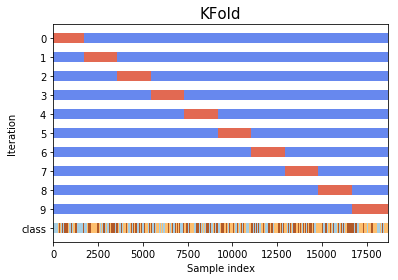

In [8]:
fig, ax = plt.subplots()
kf = KFold(n_splits=10, shuffle=False)
plot_CV_indices(kf, X_train, y_train, ax, 10)

# ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))], ['Testing set', 'Training set'], loc=(1.02, .8))
fig.savefig('Module3/visual_KFold.png')

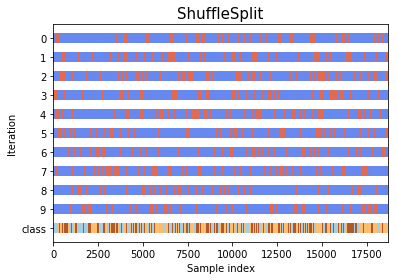

In [9]:
fig, ax = plt.subplots()
kf = ShuffleSplit(n_splits=10, test_size=0.25)
plot_CV_indices(kf, X_train, y_train, ax, 10)

# ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))], ['Testing set', 'Training set'], loc=(1.02, .8))
fig.savefig('Module3/visual_ShuffleSplit.png')

## KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

### Cross-Validation

Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 0.9999
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 0.9999
Accuracy Score: 1.0000


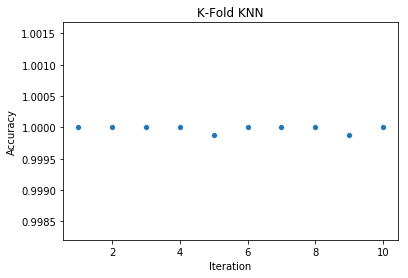

In [85]:
cross_validation_KFold(KNeighborsClassifier(), X_train, y_train, 'KNN')

Accuracy Score: 0.9998
Accuracy Score: 0.9991
Accuracy Score: 0.9997
Accuracy Score: 0.9992
Accuracy Score: 0.9996
Accuracy Score: 0.9998
Accuracy Score: 0.9994
Accuracy Score: 0.9997
Accuracy Score: 0.9995
Accuracy Score: 0.9999


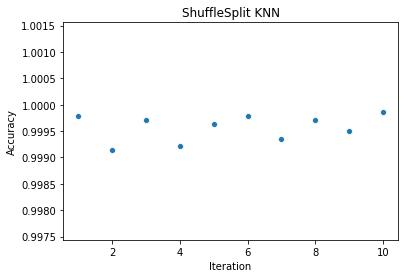

In [86]:
cross_validation_ShuffleSplit(KNeighborsClassifier(), X_train, y_train, 'KNN')

### Hyperparameter Tuning

In [76]:
n_neighbors = list(range(1, 51))
p = [1, 2]
hyperparameters = dict(n_neighbors=n_neighbors, p=p)

clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=hyperparameters, cv=2, verbose=2, refit=True)
print(clf)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)


In [77]:
clf = clf.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV] n_neighbors=1, p=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... n_neighbors=1, p=1, total=   4.5s
[CV] n_neighbors=1, p=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] ............................... n_neighbors=1, p=1, total=   4.1s
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=2, total=   1.9s
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=2, total=   1.8s
[CV] n_neighbors=2, p=1 ..............................................
[CV] ............................... n_neighbors=2, p=1, total=   4.4s
[CV] n_neighbors=2, p=1 ..............................................
[CV] ............................... n_neighbors=2, p=1, total=   5.0s
[CV] n_neighbors=2, p=2 ..............................................
[CV] ............................... n_neighbors=2, p=2, total=   1.9s
[CV] n_neighbors=2, p=2 ..............................................
[CV] ............................... n_neighbors=2, p=2, total=   1.8s
[CV] n_neighbors=3, p=1 ..............................................
[CV] .

[CV] .............................. n_neighbors=15, p=2, total=   2.4s
[CV] n_neighbors=16, p=1 .............................................
[CV] .............................. n_neighbors=16, p=1, total=   5.9s
[CV] n_neighbors=16, p=1 .............................................
[CV] .............................. n_neighbors=16, p=1, total=   5.2s
[CV] n_neighbors=16, p=2 .............................................
[CV] .............................. n_neighbors=16, p=2, total=   2.4s
[CV] n_neighbors=16, p=2 .............................................
[CV] .............................. n_neighbors=16, p=2, total=   2.5s
[CV] n_neighbors=17, p=1 .............................................
[CV] .............................. n_neighbors=17, p=1, total=   5.6s
[CV] n_neighbors=17, p=1 .............................................
[CV] .............................. n_neighbors=17, p=1, total=   5.2s
[CV] n_neighbors=17, p=2 .............................................
[CV] .

[CV] .............................. n_neighbors=30, p=1, total=   7.3s
[CV] n_neighbors=30, p=2 .............................................
[CV] .............................. n_neighbors=30, p=2, total=   2.9s
[CV] n_neighbors=30, p=2 .............................................
[CV] .............................. n_neighbors=30, p=2, total=   2.5s
[CV] n_neighbors=31, p=1 .............................................
[CV] .............................. n_neighbors=31, p=1, total=   6.8s
[CV] n_neighbors=31, p=1 .............................................
[CV] .............................. n_neighbors=31, p=1, total=   6.1s
[CV] n_neighbors=31, p=2 .............................................
[CV] .............................. n_neighbors=31, p=2, total=   3.0s
[CV] n_neighbors=31, p=2 .............................................
[CV] .............................. n_neighbors=31, p=2, total=   3.1s
[CV] n_neighbors=32, p=1 .............................................
[CV] .

[CV] .............................. n_neighbors=44, p=2, total=   3.1s
[CV] n_neighbors=45, p=1 .............................................
[CV] .............................. n_neighbors=45, p=1, total=   6.7s
[CV] n_neighbors=45, p=1 .............................................
[CV] .............................. n_neighbors=45, p=1, total=   6.2s
[CV] n_neighbors=45, p=2 .............................................
[CV] .............................. n_neighbors=45, p=2, total=   3.2s
[CV] n_neighbors=45, p=2 .............................................
[CV] .............................. n_neighbors=45, p=2, total=   3.0s
[CV] n_neighbors=46, p=1 .............................................
[CV] .............................. n_neighbors=46, p=1, total=   6.8s
[CV] n_neighbors=46, p=1 .............................................
[CV] .............................. n_neighbors=46, p=1, total=   7.6s
[CV] n_neighbors=46, p=2 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 14.2min finished


In [78]:
print(clf.best_score_)
print(clf.best_params_)

best_estimator = clf.best_estimator_
print(best_estimator)

0.8939539860888176
{'n_neighbors': 26, 'p': 1}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=26, p=1,
                     weights='uniform')


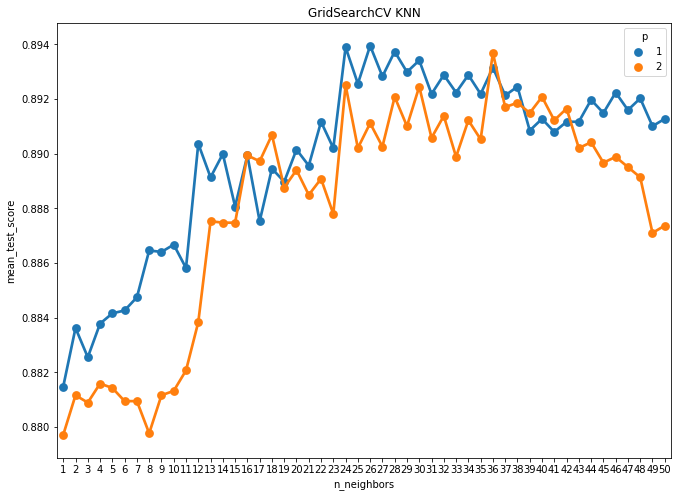

In [80]:
fig = plot_GridSearchCV_results(clf.cv_results_, 'n_neighbors', 'p', 'KNN')
fig.savefig('Module3/GridSearchCV_' + 'KNN.png')

### Results

In [87]:
clf = KNeighborsClassifier(n_neighbors=26, p=1)
clf = clf.fit(X_train, y_train)

In [88]:
y_train_prediction = clf.predict(X_train)
y_test_prediction = clf.predict(X_test)

In [89]:
print('---- Train ----')
performance_metrics(y_train, y_train_prediction)

---- Train ----


,0,1,2
0,6193,10,67
1,47,6100,63
2,22,3,6185


                        Accuracy Score: 0.9887
                              F1-Score: 0.9887
Matthews Correlation Coefficient (MCC): 0.9830
            Area Under the Curve (AUC): 0.9830


In [90]:
print('---- Test ----')
performance_metrics(y_test, y_test_prediction)

---- Test ----


,0,1,2
0,2603,22,45
1,185,2249,146
2,197,25,2538


                        Accuracy Score: 0.9226
                              F1-Score: 0.9226
Matthews Correlation Coefficient (MCC): 0.8857
            Area Under the Curve (AUC): 0.8857


In [91]:
# save model

dump(best_estimator, 'Module3/models/KNN.joblib')

['Module3/models/KNN.joblib']

## SVM

In [11]:
from sklearn.svm import SVC

### Cross-Validation

C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9631


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9672


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9667


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9642


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9671


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9679


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9664


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9653


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9672


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9682


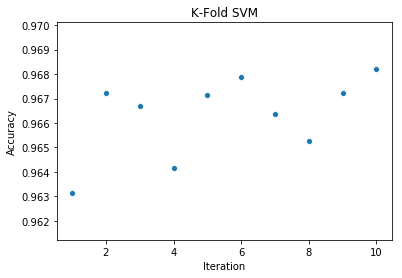

In [140]:
cross_validation_KFold(SVC(), X_train, y_train, 'SVM')

C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9635


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9627


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9638


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9636


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9646


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9625


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9633


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9653


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9632


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9631


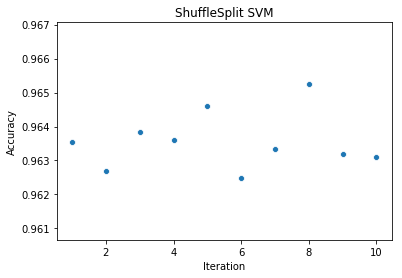

In [141]:
cross_validation_ShuffleSplit(SVC(), X_train, y_train, 'SVM')

### Hyperparameter Tuning

In [18]:
C = list([0.01, 0.1, 1, 10, 100])
gamma = list([0.001, 0.01, 0.1, 1, 10])
hyperparameters = dict(C=C, gamma=gamma)

clf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=hyperparameters, cv=2, verbose=2, refit=True)
print(clf)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)


In [19]:
clf = clf.fit(X_train, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] C=0.01, gamma=0.001 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, gamma=0.001, total=  16.7s
[CV] C=0.01, gamma=0.001 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s


[CV] .............................. C=0.01, gamma=0.001, total=  16.8s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............................... C=0.01, gamma=0.01, total=  16.1s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............................... C=0.01, gamma=0.01, total=  16.0s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ................................ C=0.01, gamma=0.1, total=  13.0s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ................................ C=0.01, gamma=0.1, total=  12.1s
[CV] C=0.01, gamma=1 .................................................
[CV] .................................. C=0.01, gamma=1, total=  15.4s
[CV] C=0.01, gamma=1 .................................................
[CV] .................................. C=0.01, gamma=1, total=  13.8s
[CV] C=0.01, gamma=10 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.5min finished


In [20]:
print(clf.best_score_)
print(clf.best_params_)

best_estimator = clf.best_estimator_
print(best_estimator)

0.9627608346709471
{'C': 100, 'gamma': 0.1}
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


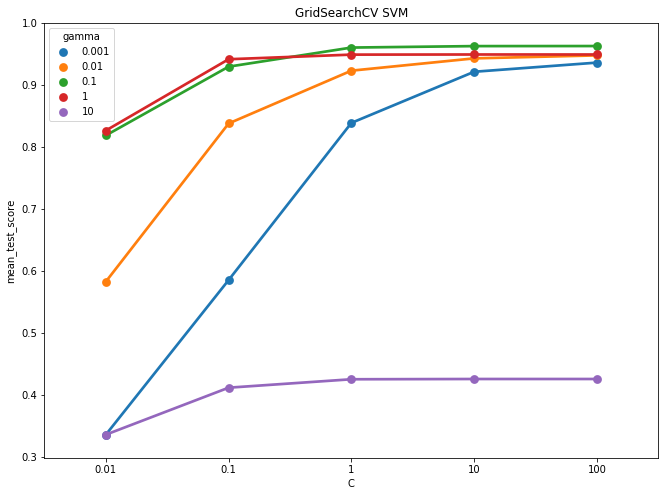

In [21]:
fig = plot_GridSearchCV_results(clf.cv_results_, 'C', 'gamma', 'SVM')
fig.savefig('Module3/GridSearchCV_' + 'SVM.png')

### Results

In [50]:
clf = SVC(kernel='rbf', C=10, gamma=0.1)
clf = clf.fit(X_train, y_train)

In [51]:
y_train_prediction = clf.predict(X_train)
y_test_prediction = clf.predict(X_test)

In [52]:
print('---- Train ----')
performance_metrics(y_train, y_train_prediction)

---- Train ----


,0,1,2
0,6270,0,0
1,0,6210,0
2,6,0,6204


                        Accuracy Score: 0.9997
                              F1-Score: 0.9997
Matthews Correlation Coefficient (MCC): 0.9995
            Area Under the Curve (AUC): 0.9995


In [53]:
print('---- Test ----')
performance_metrics(y_test, y_test_prediction)

---- Test ----


,0,1,2
0,2603,33,34
1,36,2526,18
2,122,36,2602


                        Accuracy Score: 0.9652
                              F1-Score: 0.9653
Matthews Correlation Coefficient (MCC): 0.9480
            Area Under the Curve (AUC): 0.9480


In [54]:
# save model

dump(clf, 'Module3/models/SVM.joblib')

['Module3/models/SVM.joblib']

## Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier

### Cross-Validation

C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000


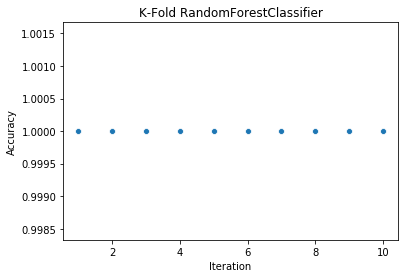

In [93]:
cross_validation_KFold(RandomForestClassifier(), X_train, y_train, 'RandomForestClassifier')

C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 1.0000


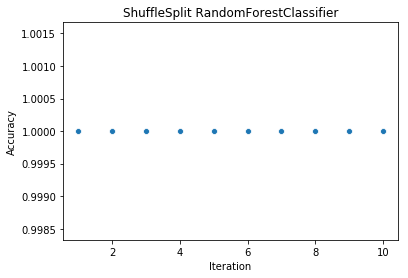

In [94]:
cross_validation_ShuffleSplit(RandomForestClassifier(), X_train, y_train, 'RandomForestClassifier')

### Hyperparameter Tuning

In [107]:
max_depth = list(range(1, 51))
min_samples_leaf = list(range(1, 21))
hyperparameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=hyperparameters, cv=2, verbose=2, refit=True)
print(clf)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [108]:
clf.fit(X_train, y_train)

Fitting 2 folds for each of 1000 candidates, totalling 2000 fits
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV] .................. max_depth=1, min_samples_leaf=1, total=   0.1s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV] .................. max_depth=1, min_samples_leaf=1, total=   0.1s
[CV] max_depth=1, min_samples_leaf=2 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=2, total=   0.1s
[CV] max_depth=1, min_samples_leaf=2 .................................
[CV] .................. max_depth=1, min_samples_leaf=2, total=   0.1s
[CV] max_depth=1, min_samples_leaf=3 .................................
[CV] .................. max_depth=1, min_samples_leaf=3, total=   0.1s
[CV] max_depth=1, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=3, total=   0.1s
[CV] max_depth=1, min_samples_leaf=4 .................................
[CV] .................. max_depth=1, min_samples_leaf=4, total=   0.1s
[CV] max_depth=1, min_samples_leaf=4 .................................
[CV] .................. max_depth=1, min_samples_leaf=4, total=   0.1s
[CV] max_depth=1, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=5, total=   0.1s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV] .................. max_depth=1, min_samples_leaf=5, total=   0.1s
[CV] max_depth=1, min_samples_leaf=6 .................................
[CV] .................. max_depth=1, min_samples_leaf=6, total=   0.1s
[CV] max_depth=1, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=6, total=   0.1s
[CV] max_depth=1, min_samples_leaf=7 .................................
[CV] .................. max_depth=1, min_samples_leaf=7, total=   0.1s
[CV] max_depth=1, min_samples_leaf=7 .................................
[CV] .................. max_depth=1, min_samples_leaf=7, total=   0.1s
[CV] max_depth=1, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=8, total=   0.1s
[CV] max_depth=1, min_samples_leaf=8 .................................
[CV] .................. max_depth=1, min_samples_leaf=8, total=   0.1s
[CV] max_depth=1, min_samples_leaf=9 .................................
[CV] .................. max_depth=1, min_samples_leaf=9, total=   0.1s
[CV] max_depth=1, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=9, total=   0.1s
[CV] max_depth=1, min_samples_leaf=10 ................................
[CV] ................. max_depth=1, min_samples_leaf=10, total=   0.1s
[CV] max_depth=1, min_samples_leaf=10 ................................
[CV] ................. max_depth=1, min_samples_leaf=10, total=   0.1s
[CV] max_depth=1, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=11, total=   0.1s
[CV] max_depth=1, min_samples_leaf=11 ................................
[CV] ................. max_depth=1, min_samples_leaf=11, total=   0.1s
[CV] max_depth=1, min_samples_leaf=12 ................................
[CV] ................. max_depth=1, min_samples_leaf=12, total=   0.1s
[CV] max_depth=1, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=12, total=   0.1s
[CV] max_depth=1, min_samples_leaf=13 ................................
[CV] ................. max_depth=1, min_samples_leaf=13, total=   0.1s
[CV] max_depth=1, min_samples_leaf=13 ................................
[CV] ................. max_depth=1, min_samples_leaf=13, total=   0.1s
[CV] max_depth=1, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=14, total=   0.1s
[CV] max_depth=1, min_samples_leaf=14 ................................
[CV] ................. max_depth=1, min_samples_leaf=14, total=   0.1s
[CV] max_depth=1, min_samples_leaf=15 ................................
[CV] ................. max_depth=1, min_samples_leaf=15, total=   0.1s
[CV] max_depth=1, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=15, total=   0.1s
[CV] max_depth=1, min_samples_leaf=16 ................................
[CV] ................. max_depth=1, min_samples_leaf=16, total=   0.1s
[CV] max_depth=1, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=16, total=   0.2s
[CV] max_depth=1, min_samples_leaf=17 ................................
[CV] ................. max_depth=1, min_samples_leaf=17, total=   0.1s
[CV] max_depth=1, min_samples_leaf=17 ................................
[CV] ................. max_depth=1, min_samples_leaf=17, total=   0.1s
[CV] max_depth=1, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=18, total=   0.1s
[CV] max_depth=1, min_samples_leaf=18 ................................
[CV] ................. max_depth=1, min_samples_leaf=18, total=   0.1s
[CV] max_depth=1, min_samples_leaf=19 ................................
[CV] ................. max_depth=1, min_samples_leaf=19, total=   0.1s
[CV] max_depth=1, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=19, total=   0.1s
[CV] max_depth=1, min_samples_leaf=20 ................................
[CV] ................. max_depth=1, min_samples_leaf=20, total=   0.1s
[CV] max_depth=1, min_samples_leaf=20 ................................
[CV] ................. max_depth=1, min_samples_leaf=20, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=1, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1 .................................
[CV] .................. max_depth=2, min_samples_leaf=1, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=2, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2 .................................
[CV] .................. max_depth=2, min_samples_leaf=2, total=   0.1s
[CV] max_depth=2, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=3, total=   0.1s
[CV] max_depth=2, min_samples_leaf=3 .................................
[CV] .................. max_depth=2, min_samples_leaf=3, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=4, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4 .................................
[CV] .................. max_depth=2, min_samples_leaf=4, total=   0.1s
[CV] max_depth=2, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=5, total=   0.2s
[CV] max_depth=2, min_samples_leaf=5 .................................
[CV] .................. max_depth=2, min_samples_leaf=5, total=   0.2s
[CV] max_depth=2, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=6, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6 .................................
[CV] .................. max_depth=2, min_samples_leaf=6, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=7, total=   0.2s
[CV] max_depth=2, min_samples_leaf=7 .................................
[CV] .................. max_depth=2, min_samples_leaf=7, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=8, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8 .................................
[CV] .................. max_depth=2, min_samples_leaf=8, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=9, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9 .................................
[CV] .................. max_depth=2, min_samples_leaf=9, total=   0.1s
[CV] max_depth=2, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=10 ................................
[CV] ................. max_depth=2, min_samples_leaf=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=11, total=   0.1s
[CV] max_depth=2, min_samples_leaf=11 ................................
[CV] ................. max_depth=2, min_samples_leaf=11, total=   0.1s
[CV] max_depth=2, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=12, total=   0.1s
[CV] max_depth=2, min_samples_leaf=12 ................................
[CV] ................. max_depth=2, min_samples_leaf=12, total=   0.1s
[CV] max_depth=2, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=13, total=   0.1s
[CV] max_depth=2, min_samples_leaf=13 ................................
[CV] ................. max_depth=2, min_samples_leaf=13, total=   0.2s
[CV] max_depth=2, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=14, total=   0.1s
[CV] max_depth=2, min_samples_leaf=14 ................................
[CV] ................. max_depth=2, min_samples_leaf=14, total=   0.1s
[CV] max_depth=2, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=15, total=   0.1s
[CV] max_depth=2, min_samples_leaf=15 ................................
[CV] ................. max_depth=2, min_samples_leaf=15, total=   0.1s
[CV] max_depth=2, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=16, total=   0.1s
[CV] max_depth=2, min_samples_leaf=16 ................................
[CV] ................. max_depth=2, min_samples_leaf=16, total=   0.1s
[CV] max_depth=2, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=17, total=   0.1s
[CV] max_depth=2, min_samples_leaf=17 ................................
[CV] ................. max_depth=2, min_samples_leaf=17, total=   0.1s
[CV] max_depth=2, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=18, total=   0.1s
[CV] max_depth=2, min_samples_leaf=18 ................................
[CV] ................. max_depth=2, min_samples_leaf=18, total=   0.1s
[CV] max_depth=2, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=19, total=   0.1s
[CV] max_depth=2, min_samples_leaf=19 ................................
[CV] ................. max_depth=2, min_samples_leaf=19, total=   0.2s
[CV] max_depth=2, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=20, total=   0.2s
[CV] max_depth=2, min_samples_leaf=20 ................................
[CV] ................. max_depth=2, min_samples_leaf=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=1, total=   0.2s
[CV] max_depth=3, min_samples_leaf=1 .................................
[CV] .................. max_depth=3, min_samples_leaf=1, total=   0.2s
[CV] max_depth=3, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=2, total=   0.2s
[CV] max_depth=3, min_samples_leaf=2 .................................
[CV] .................. max_depth=3, min_samples_leaf=2, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=3, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3 .................................
[CV] .................. max_depth=3, min_samples_leaf=3, total=   0.2s
[CV] max_depth=3, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=4, total=   0.2s
[CV] max_depth=3, min_samples_leaf=4 .................................
[CV] .................. max_depth=3, min_samples_leaf=4, total=   0.2s
[CV] max_depth=3, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=5 .................................
[CV] .................. max_depth=3, min_samples_leaf=5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=6, total=   0.2s
[CV] max_depth=3, min_samples_leaf=6 .................................
[CV] .................. max_depth=3, min_samples_leaf=6, total=   0.2s
[CV] max_depth=3, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=7, total=   0.2s
[CV] max_depth=3, min_samples_leaf=7 .................................
[CV] .................. max_depth=3, min_samples_leaf=7, total=   0.2s
[CV] max_depth=3, min_samples_leaf=8 .................................
[CV] .................. max_depth=3, min_samples_leaf=8, total=   0.2s
[CV] max_depth=3, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=8, total=   0.2s
[CV] max_depth=3, min_samples_leaf=9 .................................
[CV] .................. max_depth=3, min_samples_leaf=9, total=   0.2s
[CV] max_depth=3, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=9, total=   0.2s
[CV] max_depth=3, min_samples_leaf=10 ................................
[CV] ................. max_depth=3, min_samples_leaf=10, total=   0.2s
[CV] max_depth=3, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=10, total=   0.2s
[CV] max_depth=3, min_samples_leaf=11 ................................
[CV] ................. max_depth=3, min_samples_leaf=11, total=   0.2s
[CV] max_depth=3, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=11, total=   0.2s
[CV] max_depth=3, min_samples_leaf=12 ................................
[CV] ................. max_depth=3, min_samples_leaf=12, total=   0.2s
[CV] max_depth=3, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=12, total=   0.2s
[CV] max_depth=3, min_samples_leaf=13 ................................
[CV] ................. max_depth=3, min_samples_leaf=13, total=   0.2s
[CV] max_depth=3, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=13, total=   0.2s
[CV] max_depth=3, min_samples_leaf=14 ................................
[CV] ................. max_depth=3, min_samples_leaf=14, total=   0.2s
[CV] max_depth=3, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=14, total=   0.2s
[CV] max_depth=3, min_samples_leaf=15 ................................
[CV] ................. max_depth=3, min_samples_leaf=15, total=   0.2s
[CV] max_depth=3, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=15, total=   0.2s
[CV] max_depth=3, min_samples_leaf=16 ................................
[CV] ................. max_depth=3, min_samples_leaf=16, total=   0.2s
[CV] max_depth=3, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=16, total=   0.2s
[CV] max_depth=3, min_samples_leaf=17 ................................
[CV] ................. max_depth=3, min_samples_leaf=17, total=   0.2s
[CV] max_depth=3, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=17, total=   0.2s
[CV] max_depth=3, min_samples_leaf=18 ................................
[CV] ................. max_depth=3, min_samples_leaf=18, total=   0.1s
[CV] max_depth=3, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=18, total=   0.2s
[CV] max_depth=3, min_samples_leaf=19 ................................
[CV] ................. max_depth=3, min_samples_leaf=19, total=   0.2s
[CV] max_depth=3, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=19, total=   0.2s
[CV] max_depth=3, min_samples_leaf=20 ................................
[CV] ................. max_depth=3, min_samples_leaf=20, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=20, total=   0.2s
[CV] max_depth=4, min_samples_leaf=1 .................................
[CV] .................. max_depth=4, min_samples_leaf=1, total=   0.2s
[CV] max_depth=4, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=1, total=   0.2s
[CV] max_depth=4, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=2, total=   0.2s
[CV] max_depth=4, min_samples_leaf=2 .................................
[CV] .................. max_depth=4, min_samples_leaf=2, total=   0.2s
[CV] max_depth=4, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=3, total=   0.2s
[CV] max_depth=4, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=3, total=   0.2s
[CV] max_depth=4, min_samples_leaf=4 .................................
[CV] .................. max_depth=4, min_samples_leaf=4, total=   0.2s
[CV] max_depth=4, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=4, total=   0.2s
[CV] max_depth=4, min_samples_leaf=5 .................................
[CV] .................. max_depth=4, min_samples_leaf=5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=6, total=   0.3s
[CV] max_depth=4, min_samples_leaf=6 .................................
[CV] .................. max_depth=4, min_samples_leaf=6, total=   0.2s
[CV] max_depth=4, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=7, total=   0.2s
[CV] max_depth=4, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=7, total=   0.2s
[CV] max_depth=4, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=8, total=   0.2s
[CV] max_depth=4, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=8, total=   0.2s
[CV] max_depth=4, min_samples_leaf=9 .................................
[CV] .................. max_depth=4, min_samples_leaf=9, total=   0.2s
[CV] max_depth=4, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=9, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=11, total=   0.2s
[CV] max_depth=4, min_samples_leaf=11 ................................
[CV] ................. max_depth=4, min_samples_leaf=11, total=   0.2s
[CV] max_depth=4, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=12, total=   0.2s
[CV] max_depth=4, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=12, total=   0.2s
[CV] max_depth=4, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=13, total=   0.2s
[CV] max_depth=4, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=13, total=   0.2s
[CV] max_depth=4, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=14, total=   0.2s
[CV] max_depth=4, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=14, total=   0.2s
[CV] max_depth=4, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=15, total=   0.2s
[CV] max_depth=4, min_samples_leaf=15 ................................
[CV] ................. max_depth=4, min_samples_leaf=15, total=   0.2s
[CV] max_depth=4, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=16, total=   0.2s
[CV] max_depth=4, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=16, total=   0.2s
[CV] max_depth=4, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=17, total=   0.2s
[CV] max_depth=4, min_samples_leaf=17 ................................
[CV] ................. max_depth=4, min_samples_leaf=17, total=   0.2s
[CV] max_depth=4, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=18, total=   0.2s
[CV] max_depth=4, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=18, total=   0.2s
[CV] max_depth=4, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=19, total=   0.3s
[CV] max_depth=4, min_samples_leaf=19 ................................
[CV] ................. max_depth=4, min_samples_leaf=19, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=20, total=   0.3s
[CV] max_depth=4, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=20, total=   0.3s
[CV] max_depth=5, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=1, total=   0.3s
[CV] max_depth=5, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=1, total=   0.3s
[CV] max_depth=5, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=2, total=   0.3s
[CV] max_depth=5, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=2, total=   0.2s
[CV] max_depth=5, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=3, total=   0.3s
[CV] max_depth=5, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=3, total=   0.3s
[CV] max_depth=5, min_samples_leaf=4 .................................
[CV] .................. max_depth=5, min_samples_leaf=4, total=   0.3s
[CV] max_depth=5, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=4, total=   0.2s
[CV] max_depth=5, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=5, total=   0.3s
[CV] max_depth=5, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=5, total=   0.2s
[CV] max_depth=5, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=6, total=   0.2s
[CV] max_depth=5, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=6, total=   0.3s
[CV] max_depth=5, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=7, total=   0.2s
[CV] max_depth=5, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=7, total=   0.3s
[CV] max_depth=5, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=8, total=   0.3s
[CV] max_depth=5, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=8, total=   0.2s
[CV] max_depth=5, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=9, total=   0.3s
[CV] max_depth=5, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=9, total=   0.2s
[CV] max_depth=5, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=10, total=   0.2s
[CV] max_depth=5, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=10, total=   0.3s
[CV] max_depth=5, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=11, total=   0.3s
[CV] max_depth=5, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=11, total=   0.3s
[CV] max_depth=5, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=12, total=   0.2s
[CV] max_depth=5, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=12, total=   0.2s
[CV] max_depth=5, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=13, total=   0.3s
[CV] max_depth=5, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=13, total=   0.2s
[CV] max_depth=5, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=14, total=   0.2s
[CV] max_depth=5, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=14, total=   0.3s
[CV] max_depth=5, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=15, total=   0.2s
[CV] max_depth=5, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=15, total=   0.3s
[CV] max_depth=5, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=16, total=   0.2s
[CV] max_depth=5, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=16, total=   0.2s
[CV] max_depth=5, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=17, total=   0.2s
[CV] max_depth=5, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=17, total=   0.4s
[CV] max_depth=5, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=18, total=   0.2s
[CV] max_depth=5, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=18, total=   0.2s
[CV] max_depth=5, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=19, total=   0.2s
[CV] max_depth=5, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=19, total=   0.2s
[CV] max_depth=5, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=20, total=   0.2s
[CV] max_depth=5, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=20, total=   0.2s
[CV] max_depth=6, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=1, total=   0.3s
[CV] max_depth=6, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=1, total=   0.3s
[CV] max_depth=6, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=2, total=   0.3s
[CV] max_depth=6, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=2, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=3, total=   0.3s
[CV] max_depth=6, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=3, total=   0.3s
[CV] max_depth=6, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=4, total=   0.3s
[CV] max_depth=6, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=4, total=   0.3s
[CV] max_depth=6, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=5, total=   0.3s
[CV] max_depth=6, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=5, total=   0.3s
[CV] max_depth=6, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=6, total=   0.3s
[CV] max_depth=6, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=6, total=   0.4s
[CV] max_depth=6, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=7, total=   0.3s
[CV] max_depth=6, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=7, total=   0.3s
[CV] max_depth=6, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=8, total=   0.3s
[CV] max_depth=6, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=8, total=   0.3s
[CV] max_depth=6, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=9, total=   0.3s
[CV] max_depth=6, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=9, total=   0.3s
[CV] max_depth=6, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=10, total=   0.3s
[CV] max_depth=6, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=10, total=   0.3s
[CV] max_depth=6, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=11, total=   0.3s
[CV] max_depth=6, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=11, total=   0.3s
[CV] max_depth=6, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=12, total=   0.3s
[CV] max_depth=6, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=12, total=   0.3s
[CV] max_depth=6, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=13, total=   0.3s
[CV] max_depth=6, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=13, total=   0.4s
[CV] max_depth=6, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=14, total=   0.3s
[CV] max_depth=6, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=14, total=   0.3s
[CV] max_depth=6, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=15, total=   0.4s
[CV] max_depth=6, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=15, total=   0.3s
[CV] max_depth=6, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=16, total=   0.3s
[CV] max_depth=6, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=16, total=   0.4s
[CV] max_depth=6, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=17, total=   0.3s
[CV] max_depth=6, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=17, total=   0.3s
[CV] max_depth=6, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=18, total=   0.3s
[CV] max_depth=6, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=18, total=   0.3s
[CV] max_depth=6, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=19, total=   0.3s
[CV] max_depth=6, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=19, total=   0.3s
[CV] max_depth=6, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=20, total=   0.3s
[CV] max_depth=6, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=20, total=   0.3s
[CV] max_depth=7, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=1, total=   0.3s
[CV] max_depth=7, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=1, total=   0.3s
[CV] max_depth=7, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=2, total=   0.3s
[CV] max_depth=7, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=2, total=   0.3s
[CV] max_depth=7, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=3, total=   0.3s
[CV] max_depth=7, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=3, total=   0.3s
[CV] max_depth=7, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=4, total=   0.3s
[CV] max_depth=7, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=4, total=   0.3s
[CV] max_depth=7, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=5, total=   0.4s
[CV] max_depth=7, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=5, total=   0.3s
[CV] max_depth=7, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=6, total=   0.3s
[CV] max_depth=7, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=6, total=   0.4s
[CV] max_depth=7, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=7, total=   0.4s
[CV] max_depth=7, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=7, total=   0.3s
[CV] max_depth=7, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=8, total=   0.3s
[CV] max_depth=7, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=8, total=   0.3s
[CV] max_depth=7, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=9, total=   0.3s
[CV] max_depth=7, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=9, total=   0.3s
[CV] max_depth=7, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=10, total=   0.3s
[CV] max_depth=7, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=10, total=   0.4s
[CV] max_depth=7, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=11, total=   0.3s
[CV] max_depth=7, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=11, total=   0.4s
[CV] max_depth=7, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=12, total=   0.3s
[CV] max_depth=7, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=12, total=   0.3s
[CV] max_depth=7, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=13, total=   0.4s
[CV] max_depth=7, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=13, total=   0.3s
[CV] max_depth=7, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=14, total=   0.3s
[CV] max_depth=7, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=14, total=   0.3s
[CV] max_depth=7, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=15, total=   0.3s
[CV] max_depth=7, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=15, total=   0.3s
[CV] max_depth=7, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=16, total=   0.3s
[CV] max_depth=7, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=16, total=   0.4s
[CV] max_depth=7, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=17, total=   0.3s
[CV] max_depth=7, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=17, total=   0.3s
[CV] max_depth=7, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=18, total=   0.4s
[CV] max_depth=7, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=18, total=   0.3s
[CV] max_depth=7, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=19, total=   0.3s
[CV] max_depth=7, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=19, total=   0.3s
[CV] max_depth=7, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=20, total=   0.3s
[CV] max_depth=7, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=20, total=   0.3s
[CV] max_depth=8, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=1, total=   0.4s
[CV] max_depth=8, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=1, total=   0.4s
[CV] max_depth=8, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=2, total=   0.4s
[CV] max_depth=8, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=2, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=3, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=3, total=   0.4s
[CV] max_depth=8, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=4, total=   0.4s
[CV] max_depth=8, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=4, total=   0.3s
[CV] max_depth=8, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=5, total=   0.4s
[CV] max_depth=8, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=5, total=   0.4s
[CV] max_depth=8, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=6, total=   0.4s
[CV] max_depth=8, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=6, total=   0.4s
[CV] max_depth=8, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=7, total=   0.4s
[CV] max_depth=8, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=7, total=   0.4s
[CV] max_depth=8, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=8, total=   0.4s
[CV] max_depth=8, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=8, total=   0.4s
[CV] max_depth=8, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=9, total=   0.4s
[CV] max_depth=8, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=9, total=   0.4s
[CV] max_depth=8, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=10, total=   0.4s
[CV] max_depth=8, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=10, total=   0.4s
[CV] max_depth=8, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=11, total=   0.3s
[CV] max_depth=8, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=11, total=   0.4s
[CV] max_depth=8, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=12, total=   0.4s
[CV] max_depth=8, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=12, total=   0.3s
[CV] max_depth=8, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=13, total=   0.4s
[CV] max_depth=8, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=13, total=   0.3s
[CV] max_depth=8, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=14, total=   0.4s
[CV] max_depth=8, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=14, total=   0.4s
[CV] max_depth=8, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=15, total=   0.4s
[CV] max_depth=8, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=15, total=   0.3s
[CV] max_depth=8, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=16, total=   0.4s
[CV] max_depth=8, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=16, total=   0.4s
[CV] max_depth=8, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=17, total=   0.4s
[CV] max_depth=8, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=17, total=   0.4s
[CV] max_depth=8, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=18, total=   0.4s
[CV] max_depth=8, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=18, total=   0.4s
[CV] max_depth=8, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=19, total=   0.3s
[CV] max_depth=8, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=19, total=   0.4s
[CV] max_depth=8, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=20, total=   0.4s
[CV] max_depth=8, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=20, total=   0.3s
[CV] max_depth=9, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=1, total=   0.4s
[CV] max_depth=9, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=1, total=   0.4s
[CV] max_depth=9, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=2, total=   0.4s
[CV] max_depth=9, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=2, total=   0.4s
[CV] max_depth=9, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=3, total=   0.4s
[CV] max_depth=9, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=3, total=   0.5s
[CV] max_depth=9, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=4, total=   0.4s
[CV] max_depth=9, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=4, total=   0.4s
[CV] max_depth=9, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=5, total=   0.4s
[CV] max_depth=9, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=5, total=   0.4s
[CV] max_depth=9, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=6, total=   0.4s
[CV] max_depth=9, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=6, total=   0.4s
[CV] max_depth=9, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=7, total=   0.4s
[CV] max_depth=9, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=7, total=   0.5s
[CV] max_depth=9, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=8, total=   0.5s
[CV] max_depth=9, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=8, total=   0.4s
[CV] max_depth=9, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=9, total=   0.7s
[CV] max_depth=9, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=9, total=   0.5s
[CV] max_depth=9, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=10, total=   0.5s
[CV] max_depth=9, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=10, total=   0.4s
[CV] max_depth=9, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=11, total=   0.5s
[CV] max_depth=9, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=11, total=   0.5s
[CV] max_depth=9, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=12, total=   0.5s
[CV] max_depth=9, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=12, total=   0.4s
[CV] max_depth=9, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=13, total=   0.4s
[CV] max_depth=9, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=13, total=   0.4s
[CV] max_depth=9, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=14, total=   0.5s
[CV] max_depth=9, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=14, total=   0.5s
[CV] max_depth=9, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=15, total=   0.5s
[CV] max_depth=9, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=15, total=   0.4s
[CV] max_depth=9, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=16, total=   0.4s
[CV] max_depth=9, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=16, total=   0.4s
[CV] max_depth=9, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=17, total=   0.4s
[CV] max_depth=9, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=17, total=   0.4s
[CV] max_depth=9, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=18, total=   0.4s
[CV] max_depth=9, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=18, total=   0.4s
[CV] max_depth=9, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=19, total=   0.4s
[CV] max_depth=9, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=19, total=   0.4s
[CV] max_depth=9, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=20, total=   0.4s
[CV] max_depth=9, min_samples_leaf=20 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=20, total=   0.4s
[CV] max_depth=10, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=2, total=   0.4s
[CV] max_depth=10, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=2, total=   0.4s
[CV] max_depth=10, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=4, total=   0.4s
[CV] max_depth=10, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=4, total=   0.4s
[CV] max_depth=10, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=5, total=   0.4s
[CV] max_depth=10, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=5, total=   0.4s
[CV] max_depth=10, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=6, total=   0.4s
[CV] max_depth=10, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=6, total=   0.4s
[CV] max_depth=10, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=7, total=   0.5s
[CV] max_depth=10, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=7, total=   0.4s
[CV] max_depth=10, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=8, total=   0.4s
[CV] max_depth=10, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=8, total=   0.5s
[CV] max_depth=10, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=9, total=   0.5s
[CV] max_depth=10, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=9, total=   0.5s
[CV] max_depth=10, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=10, total=   0.4s
[CV] max_depth=10, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=10, total=   0.5s
[CV] max_depth=10, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=11, total=   0.5s
[CV] max_depth=10, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=11, total=   0.4s
[CV] max_depth=10, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=12, total=   0.4s
[CV] max_depth=10, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=12, total=   0.4s
[CV] max_depth=10, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=13, total=   0.4s
[CV] max_depth=10, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=13, total=   0.4s
[CV] max_depth=10, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=14, total=   0.4s
[CV] max_depth=10, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=14, total=   0.4s
[CV] max_depth=10, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=15, total=   0.5s
[CV] max_depth=10, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=15, total=   0.4s
[CV] max_depth=10, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=16, total=   0.4s
[CV] max_depth=10, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=16, total=   0.4s
[CV] max_depth=10, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=17, total=   0.4s
[CV] max_depth=10, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=17, total=   0.4s
[CV] max_depth=10, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=18, total=   0.5s
[CV] max_depth=10, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=18, total=   0.6s
[CV] max_depth=10, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=19, total=   0.5s
[CV] max_depth=10, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=19, total=   0.5s
[CV] max_depth=10, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=20, total=   0.5s
[CV] max_depth=10, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=20, total=   0.5s
[CV] max_depth=11, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=1, total=   0.5s
[CV] max_depth=11, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=1, total=   0.5s
[CV] max_depth=11, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=2, total=   0.5s
[CV] max_depth=11, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=2, total=   0.5s
[CV] max_depth=11, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=3, total=   0.5s
[CV] max_depth=11, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=3, total=   0.4s
[CV] max_depth=11, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=4, total=   0.4s
[CV] max_depth=11, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=4, total=   0.4s
[CV] max_depth=11, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=5, total=   0.5s
[CV] max_depth=11, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=5, total=   0.6s
[CV] max_depth=11, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=6, total=   0.5s
[CV] max_depth=11, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=6, total=   0.5s
[CV] max_depth=11, min_samples_leaf=7 ................................
[CV] ................. max_depth=11, min_samples_leaf=7, total=   0.6s
[CV] max_depth=11, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=7, total=   0.5s
[CV] max_depth=11, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=8, total=   0.4s
[CV] max_depth=11, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=8, total=   0.5s
[CV] max_depth=11, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=9, total=   0.4s
[CV] max_depth=11, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=9, total=   0.5s
[CV] max_depth=11, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=10, total=   0.4s
[CV] max_depth=11, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=10, total=   0.4s
[CV] max_depth=11, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=11, total=   0.5s
[CV] max_depth=11, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=11, total=   0.5s
[CV] max_depth=11, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=12, total=   0.4s
[CV] max_depth=11, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=12, total=   0.4s
[CV] max_depth=11, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=13, total=   0.4s
[CV] max_depth=11, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=13, total=   0.5s
[CV] max_depth=11, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=14, total=   0.4s
[CV] max_depth=11, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=14, total=   0.4s
[CV] max_depth=11, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=15, total=   0.4s
[CV] max_depth=11, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=15, total=   0.5s
[CV] max_depth=11, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=16, total=   0.5s
[CV] max_depth=11, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=16, total=   0.5s
[CV] max_depth=11, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=17, total=   0.5s
[CV] max_depth=11, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=17, total=   0.5s
[CV] max_depth=11, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=18, total=   0.5s
[CV] max_depth=11, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=18, total=   0.4s
[CV] max_depth=11, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=19, total=   0.4s
[CV] max_depth=11, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=19, total=   0.4s
[CV] max_depth=11, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=20, total=   0.4s
[CV] max_depth=11, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=20, total=   0.4s
[CV] max_depth=12, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=1, total=   0.5s
[CV] max_depth=12, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=1, total=   0.5s
[CV] max_depth=12, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=2, total=   0.5s
[CV] max_depth=12, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=2, total=   0.4s
[CV] max_depth=12, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=3, total=   0.5s
[CV] max_depth=12, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=3, total=   0.5s
[CV] max_depth=12, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=4, total=   0.5s
[CV] max_depth=12, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=4, total=   0.5s
[CV] max_depth=12, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=5, total=   0.5s
[CV] max_depth=12, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=5, total=   0.5s
[CV] max_depth=12, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=6, total=   0.4s
[CV] max_depth=12, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=6, total=   0.5s
[CV] max_depth=12, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=7, total=   0.4s
[CV] max_depth=12, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=7, total=   0.4s
[CV] max_depth=12, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=8, total=   0.4s
[CV] max_depth=12, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=8, total=   0.4s
[CV] max_depth=12, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=9, total=   0.5s
[CV] max_depth=12, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=9, total=   0.4s
[CV] max_depth=12, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=10, total=   0.4s
[CV] max_depth=12, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=10, total=   0.4s
[CV] max_depth=12, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=11, total=   0.4s
[CV] max_depth=12, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=11, total=   0.5s
[CV] max_depth=12, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=12, total=   0.4s
[CV] max_depth=12, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=12, total=   0.4s
[CV] max_depth=12, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=13, total=   0.4s
[CV] max_depth=12, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=13, total=   0.5s
[CV] max_depth=12, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=14, total=   0.5s
[CV] max_depth=12, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=14, total=   0.4s
[CV] max_depth=12, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=15, total=   0.4s
[CV] max_depth=12, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=15, total=   0.4s
[CV] max_depth=12, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=16, total=   0.4s
[CV] max_depth=12, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=16, total=   0.5s
[CV] max_depth=12, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=17, total=   0.4s
[CV] max_depth=12, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=17, total=   0.5s
[CV] max_depth=12, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=18, total=   0.4s
[CV] max_depth=12, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=18, total=   0.4s
[CV] max_depth=12, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=19, total=   0.5s
[CV] max_depth=12, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=19, total=   0.4s
[CV] max_depth=12, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=20, total=   0.4s
[CV] max_depth=12, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=20, total=   0.4s
[CV] max_depth=13, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=1, total=   0.5s
[CV] max_depth=13, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=1, total=   0.5s
[CV] max_depth=13, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=2, total=   0.5s
[CV] max_depth=13, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=2, total=   0.5s
[CV] max_depth=13, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=3, total=   0.5s
[CV] max_depth=13, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=3, total=   0.5s
[CV] max_depth=13, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=4, total=   0.5s
[CV] max_depth=13, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=4, total=   0.4s
[CV] max_depth=13, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=5, total=   0.5s
[CV] max_depth=13, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=5, total=   0.4s
[CV] max_depth=13, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=6, total=   0.5s
[CV] max_depth=13, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=6, total=   0.5s
[CV] max_depth=13, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=7, total=   0.7s
[CV] max_depth=13, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=7, total=   0.4s
[CV] max_depth=13, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=8, total=   0.5s
[CV] max_depth=13, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=8, total=   0.4s
[CV] max_depth=13, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=9, total=   0.4s
[CV] max_depth=13, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=9, total=   0.5s
[CV] max_depth=13, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=10, total=   0.4s
[CV] max_depth=13, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=10, total=   0.4s
[CV] max_depth=13, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=11, total=   0.4s
[CV] max_depth=13, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=11, total=   0.4s
[CV] max_depth=13, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=12, total=   0.4s
[CV] max_depth=13, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=12, total=   0.4s
[CV] max_depth=13, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=13, total=   0.4s
[CV] max_depth=13, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=13, total=   0.4s
[CV] max_depth=13, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=14, total=   0.5s
[CV] max_depth=13, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=14, total=   0.4s
[CV] max_depth=13, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=15, total=   0.4s
[CV] max_depth=13, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=15, total=   0.4s
[CV] max_depth=13, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=16, total=   0.4s
[CV] max_depth=13, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=16, total=   0.4s
[CV] max_depth=13, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=17, total=   0.4s
[CV] max_depth=13, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=17, total=   0.4s
[CV] max_depth=13, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=18, total=   0.4s
[CV] max_depth=13, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=18, total=   0.4s
[CV] max_depth=13, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=19, total=   0.4s
[CV] max_depth=13, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=19, total=   0.4s
[CV] max_depth=13, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=20, total=   0.4s
[CV] max_depth=13, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=20, total=   0.4s
[CV] max_depth=14, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=1, total=   0.5s
[CV] max_depth=14, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=1, total=   0.4s
[CV] max_depth=14, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=2, total=   0.5s
[CV] max_depth=14, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=2, total=   0.5s
[CV] max_depth=14, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=3, total=   0.4s
[CV] max_depth=14, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=3, total=   0.5s
[CV] max_depth=14, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=4, total=   0.4s
[CV] max_depth=14, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=4, total=   0.5s
[CV] max_depth=14, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=5, total=   0.5s
[CV] max_depth=14, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=5, total=   0.4s
[CV] max_depth=14, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=6, total=   0.5s
[CV] max_depth=14, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=6, total=   0.4s
[CV] max_depth=14, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=7, total=   0.5s
[CV] max_depth=14, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=7, total=   0.4s
[CV] max_depth=14, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=8, total=   0.4s
[CV] max_depth=14, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=8, total=   0.5s
[CV] max_depth=14, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=9, total=   0.5s
[CV] max_depth=14, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=9, total=   0.5s
[CV] max_depth=14, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=10, total=   0.4s
[CV] max_depth=14, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=10, total=   0.4s
[CV] max_depth=14, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=11, total=   0.5s
[CV] max_depth=14, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=11, total=   0.4s
[CV] max_depth=14, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=12, total=   0.4s
[CV] max_depth=14, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=12, total=   0.4s
[CV] max_depth=14, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=13, total=   0.4s
[CV] max_depth=14, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=13, total=   0.4s
[CV] max_depth=14, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=14, total=   0.4s
[CV] max_depth=14, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=14, total=   0.4s
[CV] max_depth=14, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=15, total=   0.4s
[CV] max_depth=14, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=15, total=   0.4s
[CV] max_depth=14, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=16, total=   0.4s
[CV] max_depth=14, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=16, total=   0.4s
[CV] max_depth=14, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=17, total=   0.4s
[CV] max_depth=14, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=17, total=   0.4s
[CV] max_depth=14, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=18, total=   0.4s
[CV] max_depth=14, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=18, total=   0.4s
[CV] max_depth=14, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=19, total=   0.4s
[CV] max_depth=14, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=19, total=   0.4s
[CV] max_depth=14, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=20, total=   0.4s
[CV] max_depth=14, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=20, total=   0.4s
[CV] max_depth=15, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=1, total=   0.5s
[CV] max_depth=15, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=1, total=   0.5s
[CV] max_depth=15, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=2, total=   0.5s
[CV] max_depth=15, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=2, total=   0.5s
[CV] max_depth=15, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=3, total=   0.5s
[CV] max_depth=15, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=3, total=   0.6s
[CV] max_depth=15, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=4, total=   0.5s
[CV] max_depth=15, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=4, total=   0.5s
[CV] max_depth=15, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=5, total=   0.6s
[CV] max_depth=15, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=5, total=   0.5s
[CV] max_depth=15, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=6, total=   0.5s
[CV] max_depth=15, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=6, total=   0.5s
[CV] max_depth=15, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=7, total=   0.5s
[CV] max_depth=15, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=7, total=   0.4s
[CV] max_depth=15, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=8, total=   0.4s
[CV] max_depth=15, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=8, total=   0.4s
[CV] max_depth=15, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=9, total=   0.5s
[CV] max_depth=15, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=9, total=   0.4s
[CV] max_depth=15, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=10, total=   0.5s
[CV] max_depth=15, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=10, total=   0.5s
[CV] max_depth=15, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=11, total=   0.5s
[CV] max_depth=15, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=11, total=   0.4s
[CV] max_depth=15, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=12, total=   0.4s
[CV] max_depth=15, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=12, total=   0.4s
[CV] max_depth=15, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=13, total=   0.5s
[CV] max_depth=15, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=13, total=   0.4s
[CV] max_depth=15, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=14, total=   0.4s
[CV] max_depth=15, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=14, total=   0.4s
[CV] max_depth=15, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=15, total=   0.4s
[CV] max_depth=15, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=15, total=   0.4s
[CV] max_depth=15, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=16, total=   0.4s
[CV] max_depth=15, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=16, total=   0.4s
[CV] max_depth=15, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=17, total=   0.4s
[CV] max_depth=15, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=17, total=   0.4s
[CV] max_depth=15, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=18, total=   0.4s
[CV] max_depth=15, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=18, total=   0.4s
[CV] max_depth=15, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=19, total=   0.4s
[CV] max_depth=15, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=19, total=   0.4s
[CV] max_depth=15, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=20, total=   0.4s
[CV] max_depth=15, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=20, total=   0.4s
[CV] max_depth=16, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=1, total=   0.5s
[CV] max_depth=16, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=1, total=   0.4s
[CV] max_depth=16, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=2, total=   0.5s
[CV] max_depth=16, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=2, total=   0.4s
[CV] max_depth=16, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=3, total=   0.5s
[CV] max_depth=16, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=3, total=   0.4s
[CV] max_depth=16, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=4, total=   0.4s
[CV] max_depth=16, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=4, total=   0.5s
[CV] max_depth=16, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=5, total=   0.4s
[CV] max_depth=16, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=5, total=   0.5s
[CV] max_depth=16, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=6, total=   0.4s
[CV] max_depth=16, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=6, total=   0.4s
[CV] max_depth=16, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=7, total=   0.4s
[CV] max_depth=16, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=7, total=   0.4s
[CV] max_depth=16, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=8, total=   0.5s
[CV] max_depth=16, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=8, total=   0.5s
[CV] max_depth=16, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=9, total=   0.4s
[CV] max_depth=16, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=9, total=   0.4s
[CV] max_depth=16, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=10, total=   0.5s
[CV] max_depth=16, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=10, total=   0.4s
[CV] max_depth=16, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=11, total=   0.4s
[CV] max_depth=16, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=11, total=   0.4s
[CV] max_depth=16, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=12, total=   0.4s
[CV] max_depth=16, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=12, total=   0.4s
[CV] max_depth=16, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=13, total=   0.4s
[CV] max_depth=16, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=13, total=   0.4s
[CV] max_depth=16, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=14, total=   0.4s
[CV] max_depth=16, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=14, total=   0.4s
[CV] max_depth=16, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=15, total=   0.4s
[CV] max_depth=16, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=15, total=   0.4s
[CV] max_depth=16, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=16, total=   0.4s
[CV] max_depth=16, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=16, total=   0.4s
[CV] max_depth=16, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=17, total=   0.4s
[CV] max_depth=16, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=17, total=   0.4s
[CV] max_depth=16, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=18, total=   0.4s
[CV] max_depth=16, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=18, total=   0.4s
[CV] max_depth=16, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=19, total=   0.4s
[CV] max_depth=16, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=19, total=   0.4s
[CV] max_depth=16, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=20, total=   0.4s
[CV] max_depth=16, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=20, total=   0.4s
[CV] max_depth=17, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=1, total=   0.5s
[CV] max_depth=17, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=1, total=   0.5s
[CV] max_depth=17, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=2, total=   0.5s
[CV] max_depth=17, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=2, total=   0.4s
[CV] max_depth=17, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=3, total=   0.5s
[CV] max_depth=17, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=3, total=   0.5s
[CV] max_depth=17, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=4, total=   0.5s
[CV] max_depth=17, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=4, total=   0.5s
[CV] max_depth=17, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=5, total=   0.4s
[CV] max_depth=17, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=5, total=   0.5s
[CV] max_depth=17, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=6, total=   0.4s
[CV] max_depth=17, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=6, total=   0.5s
[CV] max_depth=17, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=7, total=   0.5s
[CV] max_depth=17, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=7, total=   0.5s
[CV] max_depth=17, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=8, total=   0.5s
[CV] max_depth=17, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=8, total=   0.5s
[CV] max_depth=17, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=9, total=   0.5s
[CV] max_depth=17, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=9, total=   0.4s
[CV] max_depth=17, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=10, total=   0.5s
[CV] max_depth=17, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=10, total=   0.4s
[CV] max_depth=17, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=11, total=   0.6s
[CV] max_depth=17, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=11, total=   0.5s
[CV] max_depth=17, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=12, total=   0.4s
[CV] max_depth=17, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=12, total=   0.5s
[CV] max_depth=17, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=13, total=   0.4s
[CV] max_depth=17, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=13, total=   0.5s
[CV] max_depth=17, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=14, total=   0.4s
[CV] max_depth=17, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=14, total=   0.5s
[CV] max_depth=17, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=15, total=   0.5s
[CV] max_depth=17, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=15, total=   0.5s
[CV] max_depth=17, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=16, total=   0.5s
[CV] max_depth=17, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=16, total=   0.4s
[CV] max_depth=17, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=17, total=   0.6s
[CV] max_depth=17, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=17, total=   0.4s
[CV] max_depth=17, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=18, total=   0.5s
[CV] max_depth=17, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=18, total=   0.5s
[CV] max_depth=17, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=19, total=   0.5s
[CV] max_depth=17, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=19, total=   0.4s
[CV] max_depth=17, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=20, total=   0.4s
[CV] max_depth=17, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=20, total=   0.4s
[CV] max_depth=18, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=1, total=   0.5s
[CV] max_depth=18, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=1, total=   0.6s
[CV] max_depth=18, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=2, total=   0.5s
[CV] max_depth=18, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=2, total=   0.5s
[CV] max_depth=18, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=3, total=   0.5s
[CV] max_depth=18, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=3, total=   0.5s
[CV] max_depth=18, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=4, total=   0.5s
[CV] max_depth=18, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=4, total=   0.5s
[CV] max_depth=18, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=5, total=   0.5s
[CV] max_depth=18, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=5, total=   0.5s
[CV] max_depth=18, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=6, total=   0.4s
[CV] max_depth=18, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=6, total=   0.5s
[CV] max_depth=18, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=7, total=   0.4s
[CV] max_depth=18, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=7, total=   0.4s
[CV] max_depth=18, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=8, total=   0.4s
[CV] max_depth=18, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=8, total=   0.5s
[CV] max_depth=18, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=9, total=   0.5s
[CV] max_depth=18, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=9, total=   0.4s
[CV] max_depth=18, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=10, total=   0.4s
[CV] max_depth=18, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=10, total=   0.4s
[CV] max_depth=18, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=11, total=   0.4s
[CV] max_depth=18, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=11, total=   0.4s
[CV] max_depth=18, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=12, total=   0.4s
[CV] max_depth=18, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=12, total=   0.4s
[CV] max_depth=18, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=13, total=   0.4s
[CV] max_depth=18, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=13, total=   0.4s
[CV] max_depth=18, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=14, total=   0.4s
[CV] max_depth=18, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=14, total=   0.4s
[CV] max_depth=18, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=15, total=   0.4s
[CV] max_depth=18, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=15, total=   0.4s
[CV] max_depth=18, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=16, total=   0.4s
[CV] max_depth=18, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=16, total=   0.4s
[CV] max_depth=18, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=17, total=   0.4s
[CV] max_depth=18, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=17, total=   0.4s
[CV] max_depth=18, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=18, total=   0.4s
[CV] max_depth=18, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=18, total=   0.4s
[CV] max_depth=18, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=19, total=   0.4s
[CV] max_depth=18, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=19, total=   0.4s
[CV] max_depth=18, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=20, total=   0.4s
[CV] max_depth=18, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=20, total=   0.4s
[CV] max_depth=19, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=1, total=   0.4s
[CV] max_depth=19, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=1, total=   0.5s
[CV] max_depth=19, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=2, total=   0.5s
[CV] max_depth=19, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=2, total=   0.4s
[CV] max_depth=19, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=3, total=   0.5s
[CV] max_depth=19, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=3, total=   0.4s
[CV] max_depth=19, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=4, total=   0.4s
[CV] max_depth=19, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=4, total=   0.4s
[CV] max_depth=19, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=5, total=   0.4s
[CV] max_depth=19, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=5, total=   0.4s
[CV] max_depth=19, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=6, total=   0.4s
[CV] max_depth=19, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=6, total=   0.5s
[CV] max_depth=19, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=7, total=   0.4s
[CV] max_depth=19, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=7, total=   0.5s
[CV] max_depth=19, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=8, total=   0.4s
[CV] max_depth=19, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=8, total=   0.4s
[CV] max_depth=19, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=9, total=   0.5s
[CV] max_depth=19, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=9, total=   0.4s
[CV] max_depth=19, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=10, total=   0.4s
[CV] max_depth=19, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=10, total=   0.4s
[CV] max_depth=19, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=11, total=   0.4s
[CV] max_depth=19, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=11, total=   0.4s
[CV] max_depth=19, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=12, total=   0.4s
[CV] max_depth=19, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=12, total=   0.4s
[CV] max_depth=19, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=13, total=   0.4s
[CV] max_depth=19, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=13, total=   0.4s
[CV] max_depth=19, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=14, total=   0.4s
[CV] max_depth=19, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=14, total=   0.4s
[CV] max_depth=19, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=15, total=   0.4s
[CV] max_depth=19, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=15, total=   0.4s
[CV] max_depth=19, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=16, total=   0.4s
[CV] max_depth=19, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=16, total=   0.4s
[CV] max_depth=19, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=17, total=   0.4s
[CV] max_depth=19, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=17, total=   0.4s
[CV] max_depth=19, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=18, total=   0.4s
[CV] max_depth=19, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=18, total=   0.4s
[CV] max_depth=19, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=19, total=   0.4s
[CV] max_depth=19, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=19, total=   0.4s
[CV] max_depth=19, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=20, total=   0.4s
[CV] max_depth=19, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=20, total=   0.4s
[CV] max_depth=20, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=1, total=   0.5s
[CV] max_depth=20, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=1, total=   0.4s
[CV] max_depth=20, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=2, total=   0.5s
[CV] max_depth=20, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=2, total=   0.4s
[CV] max_depth=20, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=3, total=   0.4s
[CV] max_depth=20, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=3, total=   0.4s
[CV] max_depth=20, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=4, total=   0.4s
[CV] max_depth=20, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=4, total=   0.4s
[CV] max_depth=20, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=5, total=   0.4s
[CV] max_depth=20, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=5, total=   0.4s
[CV] max_depth=20, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=6, total=   0.5s
[CV] max_depth=20, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=6, total=   0.4s
[CV] max_depth=20, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=7, total=   0.5s
[CV] max_depth=20, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=7, total=   0.4s
[CV] max_depth=20, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=8, total=   0.4s
[CV] max_depth=20, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=8, total=   0.4s
[CV] max_depth=20, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=9, total=   0.4s
[CV] max_depth=20, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=20, min_samples_leaf=9, total=   0.4s
[CV] max_depth=20, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=10, total=   0.4s
[CV] max_depth=20, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=10, total=   0.4s
[CV] max_depth=20, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=11, total=   0.4s
[CV] max_depth=20, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=11, total=   0.4s
[CV] max_depth=20, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=12, total=   0.4s
[CV] max_depth=20, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=12, total=   0.4s
[CV] max_depth=20, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=13, total=   0.4s
[CV] max_depth=20, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=13, total=   0.4s
[CV] max_depth=20, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=14, total=   0.4s
[CV] max_depth=20, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=14, total=   0.4s
[CV] max_depth=20, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=15, total=   0.4s
[CV] max_depth=20, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=15, total=   0.4s
[CV] max_depth=20, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=16, total=   0.4s
[CV] max_depth=20, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=16, total=   0.4s
[CV] max_depth=20, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=17, total=   0.4s
[CV] max_depth=20, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=17, total=   0.4s
[CV] max_depth=20, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=18, total=   0.4s
[CV] max_depth=20, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=18, total=   0.4s
[CV] max_depth=20, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=19, total=   0.4s
[CV] max_depth=20, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=19, total=   0.4s
[CV] max_depth=20, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=20, total=   0.4s
[CV] max_depth=20, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=20, min_samples_leaf=20, total=   0.4s
[CV] max_depth=21, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=1, total=   0.4s
[CV] max_depth=21, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=1, total=   0.5s
[CV] max_depth=21, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=2, total=   0.5s
[CV] max_depth=21, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=2, total=   0.5s
[CV] max_depth=21, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=3, total=   0.5s
[CV] max_depth=21, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=3, total=   0.7s
[CV] max_depth=21, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=4, total=   0.5s
[CV] max_depth=21, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=4, total=   0.4s
[CV] max_depth=21, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=5, total=   0.5s
[CV] max_depth=21, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=5, total=   0.4s
[CV] max_depth=21, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=6, total=   0.5s
[CV] max_depth=21, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=6, total=   0.5s
[CV] max_depth=21, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=7, total=   0.5s
[CV] max_depth=21, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=7, total=   0.7s
[CV] max_depth=21, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=8, total=   0.5s
[CV] max_depth=21, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=8, total=   0.4s
[CV] max_depth=21, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=9, total=   0.4s
[CV] max_depth=21, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=21, min_samples_leaf=9, total=   0.4s
[CV] max_depth=21, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=10, total=   0.5s
[CV] max_depth=21, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=10, total=   0.4s
[CV] max_depth=21, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=11, total=   0.4s
[CV] max_depth=21, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=11, total=   0.4s
[CV] max_depth=21, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=12, total=   0.4s
[CV] max_depth=21, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=12, total=   0.4s
[CV] max_depth=21, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=13, total=   0.4s
[CV] max_depth=21, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=13, total=   0.4s
[CV] max_depth=21, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=14, total=   0.4s
[CV] max_depth=21, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=14, total=   0.4s
[CV] max_depth=21, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=15, total=   0.4s
[CV] max_depth=21, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=15, total=   0.4s
[CV] max_depth=21, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=16, total=   0.4s
[CV] max_depth=21, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=16, total=   0.4s
[CV] max_depth=21, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=17, total=   0.4s
[CV] max_depth=21, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=17, total=   0.4s
[CV] max_depth=21, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=18, total=   0.4s
[CV] max_depth=21, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=18, total=   0.5s
[CV] max_depth=21, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=19, total=   0.4s
[CV] max_depth=21, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=19, total=   0.4s
[CV] max_depth=21, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=20, total=   0.4s
[CV] max_depth=21, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=21, min_samples_leaf=20, total=   0.4s
[CV] max_depth=22, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=1, total=   0.5s
[CV] max_depth=22, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=1, total=   0.5s
[CV] max_depth=22, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=2, total=   0.5s
[CV] max_depth=22, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=2, total=   0.5s
[CV] max_depth=22, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=3, total=   0.4s
[CV] max_depth=22, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=3, total=   0.5s
[CV] max_depth=22, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=4, total=   0.4s
[CV] max_depth=22, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=4, total=   0.4s
[CV] max_depth=22, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=5, total=   0.5s
[CV] max_depth=22, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=5, total=   0.4s
[CV] max_depth=22, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=6, total=   0.4s
[CV] max_depth=22, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=6, total=   0.4s
[CV] max_depth=22, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=7, total=   0.4s
[CV] max_depth=22, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=7, total=   0.4s
[CV] max_depth=22, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=8, total=   0.4s
[CV] max_depth=22, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=8, total=   0.4s
[CV] max_depth=22, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=9, total=   0.4s
[CV] max_depth=22, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=22, min_samples_leaf=9, total=   0.4s
[CV] max_depth=22, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=10, total=   0.5s
[CV] max_depth=22, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=10, total=   0.4s
[CV] max_depth=22, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=11, total=   0.4s
[CV] max_depth=22, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=11, total=   0.4s
[CV] max_depth=22, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=12, total=   0.4s
[CV] max_depth=22, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=12, total=   0.4s
[CV] max_depth=22, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=13, total=   0.4s
[CV] max_depth=22, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=13, total=   0.4s
[CV] max_depth=22, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=14, total=   0.4s
[CV] max_depth=22, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=14, total=   0.4s
[CV] max_depth=22, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=15, total=   0.4s
[CV] max_depth=22, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=15, total=   0.4s
[CV] max_depth=22, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=16, total=   0.4s
[CV] max_depth=22, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=16, total=   0.4s
[CV] max_depth=22, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=17, total=   0.4s
[CV] max_depth=22, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=17, total=   0.4s
[CV] max_depth=22, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=18, total=   0.4s
[CV] max_depth=22, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=18, total=   0.4s
[CV] max_depth=22, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=19, total=   0.4s
[CV] max_depth=22, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=19, total=   0.4s
[CV] max_depth=22, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=20, total=   0.4s
[CV] max_depth=22, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=22, min_samples_leaf=20, total=   0.4s
[CV] max_depth=23, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=1, total=   0.5s
[CV] max_depth=23, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=1, total=   0.5s
[CV] max_depth=23, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=2, total=   0.6s
[CV] max_depth=23, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=2, total=   0.5s
[CV] max_depth=23, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=3, total=   0.5s
[CV] max_depth=23, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=3, total=   0.4s
[CV] max_depth=23, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=4, total=   0.5s
[CV] max_depth=23, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=4, total=   0.4s
[CV] max_depth=23, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=5, total=   0.4s
[CV] max_depth=23, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=5, total=   0.5s
[CV] max_depth=23, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=6, total=   0.5s
[CV] max_depth=23, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=6, total=   0.5s
[CV] max_depth=23, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=7, total=   0.4s
[CV] max_depth=23, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=7, total=   0.4s
[CV] max_depth=23, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=8, total=   0.4s
[CV] max_depth=23, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=8, total=   0.4s
[CV] max_depth=23, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=9, total=   0.5s
[CV] max_depth=23, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=23, min_samples_leaf=9, total=   0.4s
[CV] max_depth=23, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=10, total=   0.5s
[CV] max_depth=23, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=10, total=   0.5s
[CV] max_depth=23, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=11, total=   0.4s
[CV] max_depth=23, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=11, total=   0.4s
[CV] max_depth=23, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=12, total=   0.4s
[CV] max_depth=23, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=12, total=   0.4s
[CV] max_depth=23, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=13, total=   0.4s
[CV] max_depth=23, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=13, total=   0.4s
[CV] max_depth=23, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=14, total=   0.4s
[CV] max_depth=23, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=14, total=   0.4s
[CV] max_depth=23, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=15, total=   0.4s
[CV] max_depth=23, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=15, total=   0.4s
[CV] max_depth=23, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=16, total=   0.4s
[CV] max_depth=23, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=16, total=   0.4s
[CV] max_depth=23, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=17, total=   0.4s
[CV] max_depth=23, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=17, total=   0.4s
[CV] max_depth=23, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=18, total=   0.4s
[CV] max_depth=23, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=18, total=   0.4s
[CV] max_depth=23, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=19, total=   0.4s
[CV] max_depth=23, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=19, total=   0.4s
[CV] max_depth=23, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=20, total=   0.4s
[CV] max_depth=23, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=23, min_samples_leaf=20, total=   0.4s
[CV] max_depth=24, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=1, total=   0.5s
[CV] max_depth=24, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=1, total=   0.4s
[CV] max_depth=24, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=2, total=   0.5s
[CV] max_depth=24, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=2, total=   0.4s
[CV] max_depth=24, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=3, total=   0.4s
[CV] max_depth=24, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=3, total=   0.5s
[CV] max_depth=24, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=4, total=   0.4s
[CV] max_depth=24, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=4, total=   0.5s
[CV] max_depth=24, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=5, total=   0.5s
[CV] max_depth=24, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=5, total=   0.4s
[CV] max_depth=24, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=6, total=   0.6s
[CV] max_depth=24, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=6, total=   0.5s
[CV] max_depth=24, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=7, total=   0.6s
[CV] max_depth=24, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=7, total=   0.5s
[CV] max_depth=24, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=8, total=   0.5s
[CV] max_depth=24, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=8, total=   0.4s
[CV] max_depth=24, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=9, total=   0.5s
[CV] max_depth=24, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=24, min_samples_leaf=9, total=   0.4s
[CV] max_depth=24, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=10, total=   0.4s
[CV] max_depth=24, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=10, total=   0.4s
[CV] max_depth=24, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=11, total=   0.4s
[CV] max_depth=24, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=11, total=   0.4s
[CV] max_depth=24, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=12, total=   0.4s
[CV] max_depth=24, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=12, total=   0.4s
[CV] max_depth=24, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=13, total=   0.5s
[CV] max_depth=24, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=13, total=   0.4s
[CV] max_depth=24, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=14, total=   0.4s
[CV] max_depth=24, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=14, total=   0.4s
[CV] max_depth=24, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=15, total=   0.4s
[CV] max_depth=24, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=15, total=   0.4s
[CV] max_depth=24, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=16, total=   0.4s
[CV] max_depth=24, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=16, total=   0.4s
[CV] max_depth=24, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=17, total=   0.4s
[CV] max_depth=24, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=17, total=   0.4s
[CV] max_depth=24, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=18, total=   0.4s
[CV] max_depth=24, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=18, total=   0.4s
[CV] max_depth=24, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=19, total=   0.4s
[CV] max_depth=24, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=19, total=   0.4s
[CV] max_depth=24, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=20, total=   0.4s
[CV] max_depth=24, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=24, min_samples_leaf=20, total=   0.4s
[CV] max_depth=25, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=1, total=   0.5s
[CV] max_depth=25, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=1, total=   0.4s
[CV] max_depth=25, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=2, total=   0.4s
[CV] max_depth=25, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=2, total=   0.5s
[CV] max_depth=25, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=3, total=   0.4s
[CV] max_depth=25, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=3, total=   0.5s
[CV] max_depth=25, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=4, total=   0.4s
[CV] max_depth=25, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=4, total=   0.4s
[CV] max_depth=25, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=5, total=   0.4s
[CV] max_depth=25, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=5, total=   0.4s
[CV] max_depth=25, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=6, total=   0.5s
[CV] max_depth=25, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=6, total=   0.4s
[CV] max_depth=25, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=7, total=   0.5s
[CV] max_depth=25, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=7, total=   0.4s
[CV] max_depth=25, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=8, total=   0.4s
[CV] max_depth=25, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=8, total=   0.4s
[CV] max_depth=25, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=9, total=   0.4s
[CV] max_depth=25, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=25, min_samples_leaf=9, total=   0.4s
[CV] max_depth=25, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=10, total=   0.4s
[CV] max_depth=25, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=10, total=   0.4s
[CV] max_depth=25, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=11, total=   0.4s
[CV] max_depth=25, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=11, total=   0.4s
[CV] max_depth=25, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=12, total=   0.5s
[CV] max_depth=25, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=12, total=   0.4s
[CV] max_depth=25, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=13, total=   0.4s
[CV] max_depth=25, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=13, total=   0.4s
[CV] max_depth=25, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=14, total=   0.4s
[CV] max_depth=25, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=14, total=   0.4s
[CV] max_depth=25, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=15, total=   0.5s
[CV] max_depth=25, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=15, total=   0.4s
[CV] max_depth=25, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=16, total=   0.5s
[CV] max_depth=25, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=16, total=   0.5s
[CV] max_depth=25, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=17, total=   0.4s
[CV] max_depth=25, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=17, total=   0.4s
[CV] max_depth=25, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=18, total=   0.4s
[CV] max_depth=25, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=18, total=   0.4s
[CV] max_depth=25, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=19, total=   0.4s
[CV] max_depth=25, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=19, total=   0.5s
[CV] max_depth=25, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=20, total=   0.4s
[CV] max_depth=25, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=25, min_samples_leaf=20, total=   0.4s
[CV] max_depth=26, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=1, total=   0.5s
[CV] max_depth=26, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=1, total=   0.5s
[CV] max_depth=26, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=2, total=   0.5s
[CV] max_depth=26, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=2, total=   0.5s
[CV] max_depth=26, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=3, total=   0.5s
[CV] max_depth=26, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=3, total=   0.5s
[CV] max_depth=26, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=4, total=   0.5s
[CV] max_depth=26, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=4, total=   0.4s
[CV] max_depth=26, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=5, total=   0.4s
[CV] max_depth=26, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=5, total=   0.5s
[CV] max_depth=26, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=6, total=   0.4s
[CV] max_depth=26, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=6, total=   0.5s
[CV] max_depth=26, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=7, total=   0.4s
[CV] max_depth=26, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=7, total=   0.4s
[CV] max_depth=26, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=8, total=   0.4s
[CV] max_depth=26, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=8, total=   0.4s
[CV] max_depth=26, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=9, total=   0.5s
[CV] max_depth=26, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=26, min_samples_leaf=9, total=   0.4s
[CV] max_depth=26, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=10, total=   0.4s
[CV] max_depth=26, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=10, total=   0.4s
[CV] max_depth=26, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=11, total=   0.4s
[CV] max_depth=26, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=11, total=   0.4s
[CV] max_depth=26, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=12, total=   0.4s
[CV] max_depth=26, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=12, total=   0.4s
[CV] max_depth=26, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=13, total=   0.4s
[CV] max_depth=26, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=13, total=   0.4s
[CV] max_depth=26, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=14, total=   0.4s
[CV] max_depth=26, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=14, total=   0.4s
[CV] max_depth=26, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=15, total=   0.4s
[CV] max_depth=26, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=15, total=   0.4s
[CV] max_depth=26, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=16, total=   0.6s
[CV] max_depth=26, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=16, total=   0.5s
[CV] max_depth=26, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=17, total=   0.4s
[CV] max_depth=26, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=17, total=   0.4s
[CV] max_depth=26, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=18, total=   0.4s
[CV] max_depth=26, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=18, total=   0.4s
[CV] max_depth=26, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=19, total=   0.4s
[CV] max_depth=26, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=19, total=   0.4s
[CV] max_depth=26, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=20, total=   0.4s
[CV] max_depth=26, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=26, min_samples_leaf=20, total=   0.4s
[CV] max_depth=27, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=1, total=   0.5s
[CV] max_depth=27, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=1, total=   0.4s
[CV] max_depth=27, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=2, total=   0.5s
[CV] max_depth=27, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=2, total=   0.5s
[CV] max_depth=27, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=3, total=   0.5s
[CV] max_depth=27, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=3, total=   0.5s
[CV] max_depth=27, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=4, total=   0.4s
[CV] max_depth=27, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=4, total=   0.5s
[CV] max_depth=27, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=5, total=   0.4s
[CV] max_depth=27, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=5, total=   0.4s
[CV] max_depth=27, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=6, total=   0.4s
[CV] max_depth=27, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=6, total=   0.4s
[CV] max_depth=27, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=7, total=   0.5s
[CV] max_depth=27, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=7, total=   0.4s
[CV] max_depth=27, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=8, total=   0.4s
[CV] max_depth=27, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=8, total=   0.4s
[CV] max_depth=27, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=9, total=   0.4s
[CV] max_depth=27, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=27, min_samples_leaf=9, total=   0.5s
[CV] max_depth=27, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=10, total=   0.4s
[CV] max_depth=27, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=10, total=   0.4s
[CV] max_depth=27, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=11, total=   0.4s
[CV] max_depth=27, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=11, total=   0.4s
[CV] max_depth=27, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=12, total=   0.4s
[CV] max_depth=27, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=12, total=   0.4s
[CV] max_depth=27, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=13, total=   0.4s
[CV] max_depth=27, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=13, total=   0.4s
[CV] max_depth=27, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=14, total=   0.4s
[CV] max_depth=27, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=14, total=   0.4s
[CV] max_depth=27, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=15, total=   0.4s
[CV] max_depth=27, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=15, total=   0.4s
[CV] max_depth=27, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=16, total=   0.4s
[CV] max_depth=27, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=16, total=   0.4s
[CV] max_depth=27, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=17, total=   0.4s
[CV] max_depth=27, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=17, total=   0.4s
[CV] max_depth=27, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=18, total=   0.4s
[CV] max_depth=27, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=18, total=   0.4s
[CV] max_depth=27, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=19, total=   0.5s
[CV] max_depth=27, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=19, total=   0.5s
[CV] max_depth=27, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=20, total=   0.4s
[CV] max_depth=27, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=27, min_samples_leaf=20, total=   0.4s
[CV] max_depth=28, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=1, total=   0.5s
[CV] max_depth=28, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=1, total=   0.5s
[CV] max_depth=28, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=2, total=   0.5s
[CV] max_depth=28, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=2, total=   0.4s
[CV] max_depth=28, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=3, total=   0.4s
[CV] max_depth=28, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=3, total=   0.5s
[CV] max_depth=28, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=4, total=   0.5s
[CV] max_depth=28, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=4, total=   0.5s
[CV] max_depth=28, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=5, total=   0.5s
[CV] max_depth=28, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=5, total=   0.4s
[CV] max_depth=28, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=6, total=   0.5s
[CV] max_depth=28, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=6, total=   0.5s
[CV] max_depth=28, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=7, total=   0.5s
[CV] max_depth=28, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=7, total=   0.4s
[CV] max_depth=28, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=8, total=   0.5s
[CV] max_depth=28, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=8, total=   0.4s
[CV] max_depth=28, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=9, total=   0.4s
[CV] max_depth=28, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=28, min_samples_leaf=9, total=   0.4s
[CV] max_depth=28, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=10, total=   0.4s
[CV] max_depth=28, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=10, total=   0.4s
[CV] max_depth=28, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=11, total=   0.4s
[CV] max_depth=28, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=11, total=   0.4s
[CV] max_depth=28, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=12, total=   0.5s
[CV] max_depth=28, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=12, total=   0.4s
[CV] max_depth=28, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=13, total=   0.4s
[CV] max_depth=28, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=13, total=   0.4s
[CV] max_depth=28, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=14, total=   0.4s
[CV] max_depth=28, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=14, total=   0.4s
[CV] max_depth=28, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=15, total=   0.4s
[CV] max_depth=28, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=15, total=   0.4s
[CV] max_depth=28, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=16, total=   0.4s
[CV] max_depth=28, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=16, total=   0.4s
[CV] max_depth=28, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=17, total=   0.4s
[CV] max_depth=28, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=17, total=   0.4s
[CV] max_depth=28, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=18, total=   0.4s
[CV] max_depth=28, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=18, total=   0.4s
[CV] max_depth=28, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=19, total=   0.4s
[CV] max_depth=28, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=19, total=   0.4s
[CV] max_depth=28, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=20, total=   0.4s
[CV] max_depth=28, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=28, min_samples_leaf=20, total=   0.4s
[CV] max_depth=29, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=1, total=   0.5s
[CV] max_depth=29, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=1, total=   0.5s
[CV] max_depth=29, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=2, total=   0.5s
[CV] max_depth=29, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=2, total=   0.4s
[CV] max_depth=29, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=3, total=   0.5s
[CV] max_depth=29, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=3, total=   0.4s
[CV] max_depth=29, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=4, total=   0.4s
[CV] max_depth=29, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=4, total=   0.5s
[CV] max_depth=29, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=5, total=   0.4s
[CV] max_depth=29, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=5, total=   0.4s
[CV] max_depth=29, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=6, total=   0.5s
[CV] max_depth=29, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=6, total=   0.4s
[CV] max_depth=29, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=7, total=   0.5s
[CV] max_depth=29, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=7, total=   0.4s
[CV] max_depth=29, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=8, total=   0.5s
[CV] max_depth=29, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=8, total=   0.4s
[CV] max_depth=29, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=9, total=   0.4s
[CV] max_depth=29, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=29, min_samples_leaf=9, total=   0.5s
[CV] max_depth=29, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=10, total=   0.4s
[CV] max_depth=29, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=10, total=   0.5s
[CV] max_depth=29, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=11, total=   0.5s
[CV] max_depth=29, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=11, total=   0.4s
[CV] max_depth=29, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=12, total=   0.4s
[CV] max_depth=29, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=12, total=   0.4s
[CV] max_depth=29, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=13, total=   0.4s
[CV] max_depth=29, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=13, total=   0.4s
[CV] max_depth=29, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=14, total=   0.4s
[CV] max_depth=29, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=14, total=   0.4s
[CV] max_depth=29, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=15, total=   0.4s
[CV] max_depth=29, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=15, total=   0.4s
[CV] max_depth=29, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=16, total=   0.4s
[CV] max_depth=29, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=16, total=   0.5s
[CV] max_depth=29, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=17, total=   0.5s
[CV] max_depth=29, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=17, total=   0.4s
[CV] max_depth=29, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=18, total=   0.4s
[CV] max_depth=29, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=18, total=   0.5s
[CV] max_depth=29, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=19, total=   0.4s
[CV] max_depth=29, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=19, total=   0.6s
[CV] max_depth=29, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=20, total=   0.4s
[CV] max_depth=29, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=29, min_samples_leaf=20, total=   0.4s
[CV] max_depth=30, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=1, total=   0.5s
[CV] max_depth=30, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=1, total=   0.5s
[CV] max_depth=30, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=2, total=   0.5s
[CV] max_depth=30, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=2, total=   0.5s
[CV] max_depth=30, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=3, total=   0.5s
[CV] max_depth=30, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=3, total=   0.4s
[CV] max_depth=30, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=4, total=   0.4s
[CV] max_depth=30, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=4, total=   0.4s
[CV] max_depth=30, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=5, total=   0.4s
[CV] max_depth=30, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=5, total=   0.4s
[CV] max_depth=30, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=6, total=   0.4s
[CV] max_depth=30, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=6, total=   0.4s
[CV] max_depth=30, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=7, total=   0.4s
[CV] max_depth=30, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=7, total=   0.4s
[CV] max_depth=30, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=8, total=   0.4s
[CV] max_depth=30, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=8, total=   0.4s
[CV] max_depth=30, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=9, total=   0.4s
[CV] max_depth=30, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=30, min_samples_leaf=9, total=   0.4s
[CV] max_depth=30, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=10, total=   0.4s
[CV] max_depth=30, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=10, total=   0.4s
[CV] max_depth=30, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=11, total=   0.4s
[CV] max_depth=30, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=11, total=   0.4s
[CV] max_depth=30, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=12, total=   0.4s
[CV] max_depth=30, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=12, total=   0.4s
[CV] max_depth=30, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=13, total=   0.4s
[CV] max_depth=30, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=13, total=   0.4s
[CV] max_depth=30, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=14, total=   0.4s
[CV] max_depth=30, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=14, total=   0.4s
[CV] max_depth=30, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=15, total=   0.4s
[CV] max_depth=30, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=15, total=   0.4s
[CV] max_depth=30, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=16, total=   0.4s
[CV] max_depth=30, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=16, total=   0.4s
[CV] max_depth=30, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=17, total=   0.4s
[CV] max_depth=30, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=17, total=   0.4s
[CV] max_depth=30, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=18, total=   0.4s
[CV] max_depth=30, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=18, total=   0.4s
[CV] max_depth=30, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=19, total=   0.4s
[CV] max_depth=30, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=19, total=   0.4s
[CV] max_depth=30, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=20, total=   0.4s
[CV] max_depth=30, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=30, min_samples_leaf=20, total=   0.4s
[CV] max_depth=31, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=1, total=   0.5s
[CV] max_depth=31, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=1, total=   0.5s
[CV] max_depth=31, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=2, total=   0.4s
[CV] max_depth=31, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=2, total=   0.5s
[CV] max_depth=31, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=3, total=   0.4s
[CV] max_depth=31, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=3, total=   0.4s
[CV] max_depth=31, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=4, total=   0.5s
[CV] max_depth=31, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=4, total=   0.4s
[CV] max_depth=31, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=5, total=   0.4s
[CV] max_depth=31, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=5, total=   0.4s
[CV] max_depth=31, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=6, total=   0.5s
[CV] max_depth=31, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=6, total=   0.4s
[CV] max_depth=31, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=7, total=   0.4s
[CV] max_depth=31, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=7, total=   0.4s
[CV] max_depth=31, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=8, total=   0.4s
[CV] max_depth=31, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=8, total=   0.4s
[CV] max_depth=31, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=9, total=   0.4s
[CV] max_depth=31, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=31, min_samples_leaf=9, total=   0.4s
[CV] max_depth=31, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=10, total=   0.4s
[CV] max_depth=31, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=10, total=   0.4s
[CV] max_depth=31, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=11, total=   0.4s
[CV] max_depth=31, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=11, total=   0.4s
[CV] max_depth=31, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=12, total=   0.4s
[CV] max_depth=31, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=12, total=   0.4s
[CV] max_depth=31, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=13, total=   0.5s
[CV] max_depth=31, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=13, total=   0.4s
[CV] max_depth=31, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=14, total=   0.4s
[CV] max_depth=31, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=14, total=   0.4s
[CV] max_depth=31, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=15, total=   0.4s
[CV] max_depth=31, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=15, total=   0.4s
[CV] max_depth=31, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=16, total=   0.4s
[CV] max_depth=31, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=16, total=   0.4s
[CV] max_depth=31, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=17, total=   0.4s
[CV] max_depth=31, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=17, total=   0.4s
[CV] max_depth=31, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=18, total=   0.4s
[CV] max_depth=31, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=18, total=   0.4s
[CV] max_depth=31, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=19, total=   0.4s
[CV] max_depth=31, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=19, total=   0.5s
[CV] max_depth=31, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=20, total=   0.5s
[CV] max_depth=31, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=31, min_samples_leaf=20, total=   0.5s
[CV] max_depth=32, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=1, total=   0.7s
[CV] max_depth=32, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=1, total=   0.5s
[CV] max_depth=32, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=2, total=   0.4s
[CV] max_depth=32, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=2, total=   0.4s
[CV] max_depth=32, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=3, total=   0.5s
[CV] max_depth=32, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=3, total=   0.4s
[CV] max_depth=32, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=4, total=   0.5s
[CV] max_depth=32, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=4, total=   0.4s
[CV] max_depth=32, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=5, total=   0.5s
[CV] max_depth=32, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=5, total=   0.4s
[CV] max_depth=32, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=6, total=   0.4s
[CV] max_depth=32, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=6, total=   0.5s
[CV] max_depth=32, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=7, total=   0.4s
[CV] max_depth=32, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=7, total=   0.4s
[CV] max_depth=32, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=8, total=   0.5s
[CV] max_depth=32, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=8, total=   0.4s
[CV] max_depth=32, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=9, total=   0.4s
[CV] max_depth=32, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=32, min_samples_leaf=9, total=   0.4s
[CV] max_depth=32, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=10, total=   0.4s
[CV] max_depth=32, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=10, total=   0.4s
[CV] max_depth=32, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=11, total=   0.4s
[CV] max_depth=32, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=11, total=   0.4s
[CV] max_depth=32, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=12, total=   0.4s
[CV] max_depth=32, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=12, total=   0.4s
[CV] max_depth=32, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=13, total=   0.5s
[CV] max_depth=32, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=13, total=   0.4s
[CV] max_depth=32, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=14, total=   0.4s
[CV] max_depth=32, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=14, total=   0.4s
[CV] max_depth=32, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=15, total=   0.4s
[CV] max_depth=32, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=15, total=   0.4s
[CV] max_depth=32, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=16, total=   0.4s
[CV] max_depth=32, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=16, total=   0.4s
[CV] max_depth=32, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=17, total=   0.4s
[CV] max_depth=32, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=17, total=   0.4s
[CV] max_depth=32, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=18, total=   0.4s
[CV] max_depth=32, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=18, total=   0.4s
[CV] max_depth=32, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=19, total=   0.4s
[CV] max_depth=32, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=19, total=   0.4s
[CV] max_depth=32, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=20, total=   0.4s
[CV] max_depth=32, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=32, min_samples_leaf=20, total=   0.4s
[CV] max_depth=33, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=1, total=   0.5s
[CV] max_depth=33, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=1, total=   0.4s
[CV] max_depth=33, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=2, total=   0.5s
[CV] max_depth=33, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=2, total=   0.4s
[CV] max_depth=33, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=3, total=   0.5s
[CV] max_depth=33, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=3, total=   0.5s
[CV] max_depth=33, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=4, total=   0.5s
[CV] max_depth=33, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=4, total=   0.5s
[CV] max_depth=33, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=5, total=   0.5s
[CV] max_depth=33, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=5, total=   0.5s
[CV] max_depth=33, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=6, total=   0.4s
[CV] max_depth=33, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=6, total=   0.5s
[CV] max_depth=33, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=7, total=   0.5s
[CV] max_depth=33, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=7, total=   0.6s
[CV] max_depth=33, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=8, total=   0.4s
[CV] max_depth=33, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=8, total=   0.4s
[CV] max_depth=33, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=9, total=   0.5s
[CV] max_depth=33, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=33, min_samples_leaf=9, total=   0.5s
[CV] max_depth=33, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=10, total=   0.4s
[CV] max_depth=33, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=10, total=   0.4s
[CV] max_depth=33, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=11, total=   0.4s
[CV] max_depth=33, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=11, total=   0.4s
[CV] max_depth=33, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=12, total=   0.4s
[CV] max_depth=33, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=12, total=   0.5s
[CV] max_depth=33, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=13, total=   0.4s
[CV] max_depth=33, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=13, total=   0.4s
[CV] max_depth=33, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=14, total=   0.4s
[CV] max_depth=33, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=14, total=   0.4s
[CV] max_depth=33, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=15, total=   0.4s
[CV] max_depth=33, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=15, total=   0.4s
[CV] max_depth=33, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=16, total=   0.4s
[CV] max_depth=33, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=16, total=   0.4s
[CV] max_depth=33, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=17, total=   0.4s
[CV] max_depth=33, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=17, total=   0.4s
[CV] max_depth=33, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=18, total=   0.4s
[CV] max_depth=33, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=18, total=   0.4s
[CV] max_depth=33, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=19, total=   0.4s
[CV] max_depth=33, min_samples_leaf=19 ...............................
[CV] ................ max_depth=33, min_samples_leaf=19, total=   0.4s
[CV] max_depth=33, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=20, total=   0.4s
[CV] max_depth=33, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=33, min_samples_leaf=20, total=   0.4s
[CV] max_depth=34, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=1, total=   0.5s
[CV] max_depth=34, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=1, total=   0.5s
[CV] max_depth=34, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=2, total=   0.5s
[CV] max_depth=34, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=2, total=   0.4s
[CV] max_depth=34, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=3, total=   0.5s
[CV] max_depth=34, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=3, total=   0.4s
[CV] max_depth=34, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=4, total=   0.5s
[CV] max_depth=34, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=4, total=   0.5s
[CV] max_depth=34, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=5, total=   0.4s
[CV] max_depth=34, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=5, total=   0.5s
[CV] max_depth=34, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=6, total=   0.4s
[CV] max_depth=34, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=6, total=   0.4s
[CV] max_depth=34, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=7, total=   0.5s
[CV] max_depth=34, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=7, total=   0.4s
[CV] max_depth=34, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=8, total=   0.4s
[CV] max_depth=34, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=8, total=   0.4s
[CV] max_depth=34, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=9, total=   0.4s
[CV] max_depth=34, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=34, min_samples_leaf=9, total=   0.4s
[CV] max_depth=34, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=10, total=   0.5s
[CV] max_depth=34, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=10, total=   0.6s
[CV] max_depth=34, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=11, total=   0.6s
[CV] max_depth=34, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=11, total=   0.6s
[CV] max_depth=34, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=12, total=   0.6s
[CV] max_depth=34, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=12, total=   0.5s
[CV] max_depth=34, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=13, total=   0.4s
[CV] max_depth=34, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=13, total=   0.4s
[CV] max_depth=34, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=14, total=   0.5s
[CV] max_depth=34, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=14, total=   0.4s
[CV] max_depth=34, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=15, total=   0.4s
[CV] max_depth=34, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=15, total=   0.4s
[CV] max_depth=34, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=16, total=   0.6s
[CV] max_depth=34, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=16, total=   0.5s
[CV] max_depth=34, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=17, total=   0.4s
[CV] max_depth=34, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=17, total=   0.5s
[CV] max_depth=34, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=18, total=   0.4s
[CV] max_depth=34, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=18, total=   0.4s
[CV] max_depth=34, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=19, total=   0.4s
[CV] max_depth=34, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=19, total=   0.4s
[CV] max_depth=34, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=20, total=   0.4s
[CV] max_depth=34, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=34, min_samples_leaf=20, total=   0.4s
[CV] max_depth=35, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=1, total=   0.4s
[CV] max_depth=35, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=1, total=   0.5s
[CV] max_depth=35, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=2, total=   0.5s
[CV] max_depth=35, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=2, total=   0.5s
[CV] max_depth=35, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=3, total=   0.5s
[CV] max_depth=35, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=3, total=   0.5s
[CV] max_depth=35, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=4, total=   0.4s
[CV] max_depth=35, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=4, total=   0.4s
[CV] max_depth=35, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=5, total=   0.5s
[CV] max_depth=35, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=5, total=   0.5s
[CV] max_depth=35, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=6, total=   0.6s
[CV] max_depth=35, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=6, total=   0.5s
[CV] max_depth=35, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=7, total=   0.5s
[CV] max_depth=35, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=7, total=   0.4s
[CV] max_depth=35, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=8, total=   0.5s
[CV] max_depth=35, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=8, total=   0.4s
[CV] max_depth=35, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=9, total=   0.4s
[CV] max_depth=35, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=35, min_samples_leaf=9, total=   0.4s
[CV] max_depth=35, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=10, total=   0.4s
[CV] max_depth=35, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=10, total=   0.4s
[CV] max_depth=35, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=11, total=   0.4s
[CV] max_depth=35, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=11, total=   0.4s
[CV] max_depth=35, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=12, total=   0.5s
[CV] max_depth=35, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=12, total=   0.4s
[CV] max_depth=35, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=13, total=   0.5s
[CV] max_depth=35, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=13, total=   0.5s
[CV] max_depth=35, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=14, total=   0.4s
[CV] max_depth=35, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=14, total=   0.4s
[CV] max_depth=35, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=15, total=   0.4s
[CV] max_depth=35, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=15, total=   0.4s
[CV] max_depth=35, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=16, total=   0.4s
[CV] max_depth=35, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=16, total=   0.4s
[CV] max_depth=35, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=17, total=   0.4s
[CV] max_depth=35, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=17, total=   0.4s
[CV] max_depth=35, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=18, total=   0.4s
[CV] max_depth=35, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=18, total=   0.4s
[CV] max_depth=35, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=19, total=   0.4s
[CV] max_depth=35, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=19, total=   0.4s
[CV] max_depth=35, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=20, total=   0.4s
[CV] max_depth=35, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=35, min_samples_leaf=20, total=   0.4s
[CV] max_depth=36, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=1, total=   0.5s
[CV] max_depth=36, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=1, total=   0.5s
[CV] max_depth=36, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=2, total=   0.5s
[CV] max_depth=36, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=2, total=   0.5s
[CV] max_depth=36, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=3, total=   0.4s
[CV] max_depth=36, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=3, total=   0.5s
[CV] max_depth=36, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=4, total=   0.5s
[CV] max_depth=36, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=4, total=   0.5s
[CV] max_depth=36, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=5, total=   0.6s
[CV] max_depth=36, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=5, total=   0.4s
[CV] max_depth=36, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=6, total=   0.5s
[CV] max_depth=36, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=6, total=   0.5s
[CV] max_depth=36, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=7, total=   0.5s
[CV] max_depth=36, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=7, total=   0.4s
[CV] max_depth=36, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=8, total=   0.4s
[CV] max_depth=36, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=8, total=   0.4s
[CV] max_depth=36, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=9, total=   0.4s
[CV] max_depth=36, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=36, min_samples_leaf=9, total=   0.4s
[CV] max_depth=36, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=10, total=   0.4s
[CV] max_depth=36, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=10, total=   0.4s
[CV] max_depth=36, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=11, total=   0.4s
[CV] max_depth=36, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=11, total=   0.4s
[CV] max_depth=36, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=12, total=   0.5s
[CV] max_depth=36, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=12, total=   0.5s
[CV] max_depth=36, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=13, total=   0.5s
[CV] max_depth=36, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=13, total=   0.4s
[CV] max_depth=36, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=14, total=   0.5s
[CV] max_depth=36, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=14, total=   0.5s
[CV] max_depth=36, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=15, total=   0.4s
[CV] max_depth=36, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=15, total=   0.4s
[CV] max_depth=36, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=16, total=   0.5s
[CV] max_depth=36, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=16, total=   0.5s
[CV] max_depth=36, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=17, total=   0.5s
[CV] max_depth=36, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=17, total=   0.4s
[CV] max_depth=36, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=18, total=   0.5s
[CV] max_depth=36, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=18, total=   0.4s
[CV] max_depth=36, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=19, total=   0.4s
[CV] max_depth=36, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=19, total=   0.4s
[CV] max_depth=36, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=20, total=   0.5s
[CV] max_depth=36, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=36, min_samples_leaf=20, total=   0.4s
[CV] max_depth=37, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=1, total=   0.5s
[CV] max_depth=37, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=1, total=   0.5s
[CV] max_depth=37, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=2, total=   0.5s
[CV] max_depth=37, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=2, total=   0.4s
[CV] max_depth=37, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=3, total=   0.5s
[CV] max_depth=37, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=3, total=   0.5s
[CV] max_depth=37, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=4, total=   0.5s
[CV] max_depth=37, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=4, total=   0.4s
[CV] max_depth=37, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=5, total=   0.4s
[CV] max_depth=37, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=5, total=   0.4s
[CV] max_depth=37, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=6, total=   0.4s
[CV] max_depth=37, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=6, total=   0.4s
[CV] max_depth=37, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=7, total=   0.4s
[CV] max_depth=37, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=7, total=   0.4s
[CV] max_depth=37, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=8, total=   0.5s
[CV] max_depth=37, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=8, total=   0.4s
[CV] max_depth=37, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=9, total=   0.4s
[CV] max_depth=37, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=37, min_samples_leaf=9, total=   0.4s
[CV] max_depth=37, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=10, total=   0.4s
[CV] max_depth=37, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=10, total=   0.4s
[CV] max_depth=37, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=11, total=   0.4s
[CV] max_depth=37, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=11, total=   0.5s
[CV] max_depth=37, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=12, total=   0.5s
[CV] max_depth=37, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=12, total=   0.4s
[CV] max_depth=37, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=13, total=   0.4s
[CV] max_depth=37, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=13, total=   0.4s
[CV] max_depth=37, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=14, total=   0.4s
[CV] max_depth=37, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=14, total=   0.4s
[CV] max_depth=37, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=15, total=   0.4s
[CV] max_depth=37, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=15, total=   0.4s
[CV] max_depth=37, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=16, total=   0.4s
[CV] max_depth=37, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=16, total=   0.4s
[CV] max_depth=37, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=17, total=   0.4s
[CV] max_depth=37, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=17, total=   0.4s
[CV] max_depth=37, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=18, total=   0.4s
[CV] max_depth=37, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=18, total=   0.4s
[CV] max_depth=37, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=19, total=   0.4s
[CV] max_depth=37, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=19, total=   0.4s
[CV] max_depth=37, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=20, total=   0.4s
[CV] max_depth=37, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=37, min_samples_leaf=20, total=   0.4s
[CV] max_depth=38, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=1, total=   0.5s
[CV] max_depth=38, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=1, total=   0.4s
[CV] max_depth=38, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=2, total=   0.5s
[CV] max_depth=38, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=2, total=   0.5s
[CV] max_depth=38, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=3, total=   0.4s
[CV] max_depth=38, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=3, total=   0.4s
[CV] max_depth=38, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=4, total=   0.4s
[CV] max_depth=38, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=4, total=   0.4s
[CV] max_depth=38, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=5, total=   0.4s
[CV] max_depth=38, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=5, total=   0.4s
[CV] max_depth=38, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=6, total=   0.5s
[CV] max_depth=38, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=6, total=   0.4s
[CV] max_depth=38, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=7, total=   0.4s
[CV] max_depth=38, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=7, total=   0.5s
[CV] max_depth=38, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=8, total=   0.4s
[CV] max_depth=38, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=8, total=   0.4s
[CV] max_depth=38, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=9, total=   0.4s
[CV] max_depth=38, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=38, min_samples_leaf=9, total=   0.4s
[CV] max_depth=38, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=10, total=   0.4s
[CV] max_depth=38, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=10, total=   0.4s
[CV] max_depth=38, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=11, total=   0.4s
[CV] max_depth=38, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=11, total=   0.4s
[CV] max_depth=38, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=12, total=   0.4s
[CV] max_depth=38, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=12, total=   0.4s
[CV] max_depth=38, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=13, total=   0.4s
[CV] max_depth=38, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=13, total=   0.4s
[CV] max_depth=38, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=14, total=   0.4s
[CV] max_depth=38, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=14, total=   0.4s
[CV] max_depth=38, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=15, total=   0.4s
[CV] max_depth=38, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=15, total=   0.4s
[CV] max_depth=38, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=16, total=   0.4s
[CV] max_depth=38, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=16, total=   0.4s
[CV] max_depth=38, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=17, total=   0.4s
[CV] max_depth=38, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=17, total=   0.4s
[CV] max_depth=38, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=18, total=   0.4s
[CV] max_depth=38, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=18, total=   0.4s
[CV] max_depth=38, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=19, total=   0.4s
[CV] max_depth=38, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=19, total=   0.4s
[CV] max_depth=38, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=20, total=   0.4s
[CV] max_depth=38, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=38, min_samples_leaf=20, total=   0.4s
[CV] max_depth=39, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=1, total=   0.4s
[CV] max_depth=39, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=1, total=   0.4s
[CV] max_depth=39, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=2, total=   0.5s
[CV] max_depth=39, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=2, total=   0.5s
[CV] max_depth=39, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=3, total=   0.5s
[CV] max_depth=39, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=3, total=   0.5s
[CV] max_depth=39, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=4, total=   0.5s
[CV] max_depth=39, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=4, total=   0.5s
[CV] max_depth=39, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=5, total=   0.4s
[CV] max_depth=39, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=5, total=   0.5s
[CV] max_depth=39, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=6, total=   0.4s
[CV] max_depth=39, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=6, total=   0.5s
[CV] max_depth=39, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=7, total=   0.4s
[CV] max_depth=39, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=7, total=   0.4s
[CV] max_depth=39, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=8, total=   0.5s
[CV] max_depth=39, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=8, total=   0.4s
[CV] max_depth=39, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=9, total=   0.5s
[CV] max_depth=39, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=39, min_samples_leaf=9, total=   0.4s
[CV] max_depth=39, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=10, total=   0.4s
[CV] max_depth=39, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=10, total=   0.4s
[CV] max_depth=39, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=11, total=   0.4s
[CV] max_depth=39, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=11, total=   0.4s
[CV] max_depth=39, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=12, total=   0.4s
[CV] max_depth=39, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=12, total=   0.4s
[CV] max_depth=39, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=13, total=   0.5s
[CV] max_depth=39, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=13, total=   0.4s
[CV] max_depth=39, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=14, total=   0.4s
[CV] max_depth=39, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=14, total=   0.4s
[CV] max_depth=39, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=15, total=   0.4s
[CV] max_depth=39, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=15, total=   0.4s
[CV] max_depth=39, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=16, total=   0.4s
[CV] max_depth=39, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=16, total=   0.4s
[CV] max_depth=39, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=17, total=   0.4s
[CV] max_depth=39, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=17, total=   0.4s
[CV] max_depth=39, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=18, total=   0.4s
[CV] max_depth=39, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=18, total=   0.4s
[CV] max_depth=39, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=19, total=   0.4s
[CV] max_depth=39, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=19, total=   0.6s
[CV] max_depth=39, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=20, total=   0.4s
[CV] max_depth=39, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=39, min_samples_leaf=20, total=   0.4s
[CV] max_depth=40, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=1, total=   0.5s
[CV] max_depth=40, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=1, total=   0.4s
[CV] max_depth=40, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=2, total=   0.5s
[CV] max_depth=40, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=2, total=   0.4s
[CV] max_depth=40, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=3, total=   0.5s
[CV] max_depth=40, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=3, total=   0.4s
[CV] max_depth=40, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=4, total=   0.5s
[CV] max_depth=40, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=4, total=   0.4s
[CV] max_depth=40, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=5, total=   0.4s
[CV] max_depth=40, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=5, total=   0.4s
[CV] max_depth=40, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=6, total=   0.4s
[CV] max_depth=40, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=6, total=   0.4s
[CV] max_depth=40, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=7, total=   0.5s
[CV] max_depth=40, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=7, total=   0.4s
[CV] max_depth=40, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=8, total=   0.5s
[CV] max_depth=40, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=8, total=   0.4s
[CV] max_depth=40, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=9, total=   0.4s
[CV] max_depth=40, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=40, min_samples_leaf=9, total=   0.4s
[CV] max_depth=40, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=10, total=   0.4s
[CV] max_depth=40, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=10, total=   0.4s
[CV] max_depth=40, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=11, total=   0.4s
[CV] max_depth=40, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=11, total=   0.4s
[CV] max_depth=40, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=12, total=   0.5s
[CV] max_depth=40, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=12, total=   0.4s
[CV] max_depth=40, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=13, total=   0.5s
[CV] max_depth=40, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=13, total=   0.4s
[CV] max_depth=40, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=14, total=   0.4s
[CV] max_depth=40, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=14, total=   0.4s
[CV] max_depth=40, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=15, total=   0.4s
[CV] max_depth=40, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=15, total=   0.4s
[CV] max_depth=40, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=16, total=   0.4s
[CV] max_depth=40, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=16, total=   0.4s
[CV] max_depth=40, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=17, total=   0.5s
[CV] max_depth=40, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=17, total=   0.4s
[CV] max_depth=40, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=18, total=   0.4s
[CV] max_depth=40, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=18, total=   0.4s
[CV] max_depth=40, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=19, total=   0.4s
[CV] max_depth=40, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=19, total=   0.4s
[CV] max_depth=40, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=20, total=   0.4s
[CV] max_depth=40, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=40, min_samples_leaf=20, total=   0.4s
[CV] max_depth=41, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=1, total=   0.5s
[CV] max_depth=41, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=1, total=   0.4s
[CV] max_depth=41, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=2, total=   0.5s
[CV] max_depth=41, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=2, total=   0.4s
[CV] max_depth=41, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=3, total=   0.4s
[CV] max_depth=41, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=3, total=   0.5s
[CV] max_depth=41, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=4, total=   0.4s
[CV] max_depth=41, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=4, total=   0.5s
[CV] max_depth=41, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=5, total=   0.4s
[CV] max_depth=41, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=5, total=   0.4s
[CV] max_depth=41, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=6, total=   0.4s
[CV] max_depth=41, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=6, total=   0.4s
[CV] max_depth=41, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=7, total=   0.5s
[CV] max_depth=41, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=7, total=   0.4s
[CV] max_depth=41, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=8, total=   0.4s
[CV] max_depth=41, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=8, total=   0.4s
[CV] max_depth=41, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=9, total=   0.4s
[CV] max_depth=41, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=41, min_samples_leaf=9, total=   0.4s
[CV] max_depth=41, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=10, total=   0.4s
[CV] max_depth=41, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=10, total=   0.4s
[CV] max_depth=41, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=11, total=   0.4s
[CV] max_depth=41, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=11, total=   0.4s
[CV] max_depth=41, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=12, total=   0.4s
[CV] max_depth=41, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=12, total=   0.4s
[CV] max_depth=41, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=13, total=   0.5s
[CV] max_depth=41, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=13, total=   0.5s
[CV] max_depth=41, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=14, total=   0.5s
[CV] max_depth=41, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=14, total=   0.4s
[CV] max_depth=41, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=15, total=   0.5s
[CV] max_depth=41, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=15, total=   0.5s
[CV] max_depth=41, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=16, total=   0.6s
[CV] max_depth=41, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=16, total=   0.5s
[CV] max_depth=41, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=17, total=   0.5s
[CV] max_depth=41, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=17, total=   0.4s
[CV] max_depth=41, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=18, total=   0.5s
[CV] max_depth=41, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=18, total=   0.4s
[CV] max_depth=41, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=19, total=   0.4s
[CV] max_depth=41, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=19, total=   0.4s
[CV] max_depth=41, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=20, total=   0.4s
[CV] max_depth=41, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=41, min_samples_leaf=20, total=   0.4s
[CV] max_depth=42, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=1, total=   0.5s
[CV] max_depth=42, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=1, total=   0.5s
[CV] max_depth=42, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=2, total=   0.5s
[CV] max_depth=42, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=2, total=   0.5s
[CV] max_depth=42, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=3, total=   0.5s
[CV] max_depth=42, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=3, total=   0.5s
[CV] max_depth=42, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=4, total=   0.5s
[CV] max_depth=42, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=4, total=   0.5s
[CV] max_depth=42, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=5, total=   0.5s
[CV] max_depth=42, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=5, total=   0.4s
[CV] max_depth=42, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=6, total=   0.5s
[CV] max_depth=42, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=6, total=   0.5s
[CV] max_depth=42, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=7, total=   0.4s
[CV] max_depth=42, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=7, total=   0.4s
[CV] max_depth=42, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=8, total=   0.4s
[CV] max_depth=42, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=8, total=   0.5s
[CV] max_depth=42, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=9, total=   0.5s
[CV] max_depth=42, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=42, min_samples_leaf=9, total=   0.5s
[CV] max_depth=42, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=10, total=   0.5s
[CV] max_depth=42, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=10, total=   0.4s
[CV] max_depth=42, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=11, total=   0.5s
[CV] max_depth=42, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=11, total=   0.4s
[CV] max_depth=42, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=12, total=   0.5s
[CV] max_depth=42, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=12, total=   0.4s
[CV] max_depth=42, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=13, total=   0.4s
[CV] max_depth=42, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=13, total=   0.4s
[CV] max_depth=42, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=14, total=   0.5s
[CV] max_depth=42, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=14, total=   0.4s
[CV] max_depth=42, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=15, total=   0.4s
[CV] max_depth=42, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=15, total=   0.4s
[CV] max_depth=42, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=16, total=   0.4s
[CV] max_depth=42, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=16, total=   0.4s
[CV] max_depth=42, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=17, total=   0.4s
[CV] max_depth=42, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=17, total=   0.4s
[CV] max_depth=42, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=18, total=   0.4s
[CV] max_depth=42, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=18, total=   0.4s
[CV] max_depth=42, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=19, total=   0.4s
[CV] max_depth=42, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=19, total=   0.4s
[CV] max_depth=42, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=20, total=   0.4s
[CV] max_depth=42, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=42, min_samples_leaf=20, total=   0.4s
[CV] max_depth=43, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=1, total=   0.4s
[CV] max_depth=43, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=1, total=   0.5s
[CV] max_depth=43, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=2, total=   0.4s
[CV] max_depth=43, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=2, total=   0.4s
[CV] max_depth=43, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=3, total=   0.5s
[CV] max_depth=43, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=3, total=   0.4s
[CV] max_depth=43, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=4, total=   0.5s
[CV] max_depth=43, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=4, total=   0.4s
[CV] max_depth=43, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=5, total=   0.4s
[CV] max_depth=43, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=5, total=   0.4s
[CV] max_depth=43, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=6, total=   0.4s
[CV] max_depth=43, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=6, total=   0.4s
[CV] max_depth=43, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=7, total=   0.4s
[CV] max_depth=43, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=7, total=   0.4s
[CV] max_depth=43, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=8, total=   0.4s
[CV] max_depth=43, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=8, total=   0.4s
[CV] max_depth=43, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=9, total=   0.4s
[CV] max_depth=43, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=43, min_samples_leaf=9, total=   0.4s
[CV] max_depth=43, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=10, total=   0.4s
[CV] max_depth=43, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=10, total=   0.4s
[CV] max_depth=43, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=11, total=   0.4s
[CV] max_depth=43, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=11, total=   0.4s
[CV] max_depth=43, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=12, total=   0.4s
[CV] max_depth=43, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=12, total=   0.4s
[CV] max_depth=43, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=13, total=   0.4s
[CV] max_depth=43, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=13, total=   0.4s
[CV] max_depth=43, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=14, total=   0.4s
[CV] max_depth=43, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=14, total=   0.4s
[CV] max_depth=43, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=15, total=   0.4s
[CV] max_depth=43, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=15, total=   0.4s
[CV] max_depth=43, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=16, total=   0.4s
[CV] max_depth=43, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=16, total=   0.4s
[CV] max_depth=43, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=17, total=   0.4s
[CV] max_depth=43, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=17, total=   0.4s
[CV] max_depth=43, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=18, total=   0.4s
[CV] max_depth=43, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=18, total=   0.4s
[CV] max_depth=43, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=19, total=   0.4s
[CV] max_depth=43, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=19, total=   0.4s
[CV] max_depth=43, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=20, total=   0.4s
[CV] max_depth=43, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=43, min_samples_leaf=20, total=   0.4s
[CV] max_depth=44, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=1, total=   0.5s
[CV] max_depth=44, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=1, total=   0.4s
[CV] max_depth=44, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=2, total=   0.5s
[CV] max_depth=44, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=2, total=   0.4s
[CV] max_depth=44, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=3, total=   0.5s
[CV] max_depth=44, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=3, total=   0.4s
[CV] max_depth=44, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=4, total=   0.4s
[CV] max_depth=44, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=4, total=   0.5s
[CV] max_depth=44, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=5, total=   0.4s
[CV] max_depth=44, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=5, total=   0.5s
[CV] max_depth=44, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=6, total=   0.4s
[CV] max_depth=44, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=6, total=   0.5s
[CV] max_depth=44, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=7, total=   0.5s
[CV] max_depth=44, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=7, total=   0.4s
[CV] max_depth=44, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=8, total=   0.5s
[CV] max_depth=44, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=8, total=   0.5s
[CV] max_depth=44, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=9, total=   0.5s
[CV] max_depth=44, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=44, min_samples_leaf=9, total=   0.4s
[CV] max_depth=44, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=10, total=   0.5s
[CV] max_depth=44, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=10, total=   0.4s
[CV] max_depth=44, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=11, total=   0.4s
[CV] max_depth=44, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=11, total=   0.5s
[CV] max_depth=44, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=12, total=   0.4s
[CV] max_depth=44, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=12, total=   0.4s
[CV] max_depth=44, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=13, total=   0.4s
[CV] max_depth=44, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=13, total=   0.4s
[CV] max_depth=44, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=14, total=   0.4s
[CV] max_depth=44, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=14, total=   0.4s
[CV] max_depth=44, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=15, total=   0.4s
[CV] max_depth=44, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=15, total=   0.5s
[CV] max_depth=44, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=16, total=   0.4s
[CV] max_depth=44, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=16, total=   0.4s
[CV] max_depth=44, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=17, total=   0.4s
[CV] max_depth=44, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=17, total=   0.4s
[CV] max_depth=44, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=18, total=   0.4s
[CV] max_depth=44, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=18, total=   0.4s
[CV] max_depth=44, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=19, total=   0.4s
[CV] max_depth=44, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=19, total=   0.4s
[CV] max_depth=44, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=20, total=   0.4s
[CV] max_depth=44, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=44, min_samples_leaf=20, total=   0.4s
[CV] max_depth=45, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=1, total=   0.5s
[CV] max_depth=45, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=1, total=   0.5s
[CV] max_depth=45, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=2, total=   0.5s
[CV] max_depth=45, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=2, total=   0.4s
[CV] max_depth=45, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=3, total=   0.4s
[CV] max_depth=45, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=3, total=   0.5s
[CV] max_depth=45, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=4, total=   0.4s
[CV] max_depth=45, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=4, total=   0.5s
[CV] max_depth=45, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=5, total=   0.4s
[CV] max_depth=45, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=5, total=   0.4s
[CV] max_depth=45, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=6, total=   0.4s
[CV] max_depth=45, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=6, total=   0.4s
[CV] max_depth=45, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=7, total=   0.4s
[CV] max_depth=45, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=7, total=   0.4s
[CV] max_depth=45, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=8, total=   0.4s
[CV] max_depth=45, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=8, total=   0.4s
[CV] max_depth=45, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=9, total=   0.4s
[CV] max_depth=45, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=45, min_samples_leaf=9, total=   0.5s
[CV] max_depth=45, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=10, total=   0.4s
[CV] max_depth=45, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=10, total=   0.4s
[CV] max_depth=45, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=11, total=   0.4s
[CV] max_depth=45, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=11, total=   0.4s
[CV] max_depth=45, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=12, total=   0.4s
[CV] max_depth=45, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=12, total=   0.5s
[CV] max_depth=45, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=13, total=   0.4s
[CV] max_depth=45, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=13, total=   0.4s
[CV] max_depth=45, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=14, total=   0.4s
[CV] max_depth=45, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=14, total=   0.5s
[CV] max_depth=45, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=15, total=   0.4s
[CV] max_depth=45, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=15, total=   0.4s
[CV] max_depth=45, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=16, total=   0.5s
[CV] max_depth=45, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=16, total=   0.4s
[CV] max_depth=45, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=17, total=   0.5s
[CV] max_depth=45, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=17, total=   0.4s
[CV] max_depth=45, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=18, total=   0.5s
[CV] max_depth=45, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=18, total=   0.4s
[CV] max_depth=45, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=19, total=   0.4s
[CV] max_depth=45, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=19, total=   0.4s
[CV] max_depth=45, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=20, total=   0.4s
[CV] max_depth=45, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=45, min_samples_leaf=20, total=   0.4s
[CV] max_depth=46, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=1, total=   0.6s
[CV] max_depth=46, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=1, total=   0.5s
[CV] max_depth=46, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=2, total=   0.5s
[CV] max_depth=46, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=2, total=   0.5s
[CV] max_depth=46, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=3, total=   0.5s
[CV] max_depth=46, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=3, total=   0.5s
[CV] max_depth=46, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=4, total=   0.5s
[CV] max_depth=46, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=4, total=   0.5s
[CV] max_depth=46, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=5, total=   0.5s
[CV] max_depth=46, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=5, total=   0.5s
[CV] max_depth=46, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=6, total=   0.6s
[CV] max_depth=46, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=6, total=   0.5s
[CV] max_depth=46, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=7, total=   0.5s
[CV] max_depth=46, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=7, total=   0.5s
[CV] max_depth=46, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=8, total=   0.5s
[CV] max_depth=46, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=8, total=   0.5s
[CV] max_depth=46, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=9, total=   0.5s
[CV] max_depth=46, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=46, min_samples_leaf=9, total=   0.5s
[CV] max_depth=46, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=10, total=   0.5s
[CV] max_depth=46, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=10, total=   0.5s
[CV] max_depth=46, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=11, total=   0.5s
[CV] max_depth=46, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=11, total=   0.5s
[CV] max_depth=46, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=12, total=   0.5s
[CV] max_depth=46, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=12, total=   0.5s
[CV] max_depth=46, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=13, total=   0.5s
[CV] max_depth=46, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=13, total=   0.4s
[CV] max_depth=46, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=14, total=   0.5s
[CV] max_depth=46, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=14, total=   0.4s
[CV] max_depth=46, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=15, total=   0.4s
[CV] max_depth=46, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=15, total=   0.4s
[CV] max_depth=46, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=16, total=   0.4s
[CV] max_depth=46, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=16, total=   0.4s
[CV] max_depth=46, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=17, total=   0.5s
[CV] max_depth=46, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=17, total=   0.4s
[CV] max_depth=46, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=18, total=   0.4s
[CV] max_depth=46, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=18, total=   0.4s
[CV] max_depth=46, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=19, total=   0.4s
[CV] max_depth=46, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=19, total=   0.5s
[CV] max_depth=46, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=20, total=   0.4s
[CV] max_depth=46, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=46, min_samples_leaf=20, total=   0.4s
[CV] max_depth=47, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=1, total=   0.5s
[CV] max_depth=47, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=1, total=   0.5s
[CV] max_depth=47, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=2, total=   0.5s
[CV] max_depth=47, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=2, total=   0.4s
[CV] max_depth=47, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=3, total=   0.4s
[CV] max_depth=47, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=3, total=   0.5s
[CV] max_depth=47, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=4, total=   0.4s
[CV] max_depth=47, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=4, total=   0.5s
[CV] max_depth=47, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=5, total=   0.4s
[CV] max_depth=47, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=5, total=   0.4s
[CV] max_depth=47, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=6, total=   0.5s
[CV] max_depth=47, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=6, total=   0.4s
[CV] max_depth=47, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=7, total=   0.5s
[CV] max_depth=47, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=7, total=   0.4s
[CV] max_depth=47, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=8, total=   0.4s
[CV] max_depth=47, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=8, total=   0.4s
[CV] max_depth=47, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=9, total=   0.4s
[CV] max_depth=47, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=47, min_samples_leaf=9, total=   0.4s
[CV] max_depth=47, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=10, total=   0.4s
[CV] max_depth=47, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=10, total=   0.4s
[CV] max_depth=47, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=11, total=   0.4s
[CV] max_depth=47, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=11, total=   0.4s
[CV] max_depth=47, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=12, total=   0.4s
[CV] max_depth=47, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=12, total=   0.4s
[CV] max_depth=47, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=13, total=   0.4s
[CV] max_depth=47, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=13, total=   0.4s
[CV] max_depth=47, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=14, total=   0.4s
[CV] max_depth=47, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=14, total=   0.4s
[CV] max_depth=47, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=15, total=   0.4s
[CV] max_depth=47, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=15, total=   0.4s
[CV] max_depth=47, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=16, total=   0.4s
[CV] max_depth=47, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=16, total=   0.4s
[CV] max_depth=47, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=17, total=   0.4s
[CV] max_depth=47, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=17, total=   0.4s
[CV] max_depth=47, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=18, total=   0.4s
[CV] max_depth=47, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=18, total=   0.4s
[CV] max_depth=47, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=19, total=   0.4s
[CV] max_depth=47, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=19, total=   0.4s
[CV] max_depth=47, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=20, total=   0.4s
[CV] max_depth=47, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=47, min_samples_leaf=20, total=   0.4s
[CV] max_depth=48, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=1, total=   0.5s
[CV] max_depth=48, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=1, total=   0.5s
[CV] max_depth=48, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=2, total=   0.5s
[CV] max_depth=48, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=2, total=   0.5s
[CV] max_depth=48, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=3, total=   0.5s
[CV] max_depth=48, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=3, total=   0.5s
[CV] max_depth=48, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=4, total=   0.5s
[CV] max_depth=48, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=4, total=   0.5s
[CV] max_depth=48, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=5, total=   0.4s
[CV] max_depth=48, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=5, total=   0.5s
[CV] max_depth=48, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=6, total=   0.4s
[CV] max_depth=48, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=6, total=   0.4s
[CV] max_depth=48, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=7, total=   0.5s
[CV] max_depth=48, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=7, total=   0.4s
[CV] max_depth=48, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=8, total=   0.4s
[CV] max_depth=48, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=8, total=   0.4s
[CV] max_depth=48, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=9, total=   0.4s
[CV] max_depth=48, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=48, min_samples_leaf=9, total=   0.4s
[CV] max_depth=48, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=10, total=   0.4s
[CV] max_depth=48, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=10, total=   0.4s
[CV] max_depth=48, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=11, total=   0.4s
[CV] max_depth=48, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=11, total=   0.4s
[CV] max_depth=48, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=12, total=   0.4s
[CV] max_depth=48, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=12, total=   0.4s
[CV] max_depth=48, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=13, total=   0.4s
[CV] max_depth=48, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=13, total=   0.4s
[CV] max_depth=48, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=14, total=   0.4s
[CV] max_depth=48, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=14, total=   0.4s
[CV] max_depth=48, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=15, total=   0.4s
[CV] max_depth=48, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=15, total=   0.4s
[CV] max_depth=48, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=16, total=   0.4s
[CV] max_depth=48, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=16, total=   0.4s
[CV] max_depth=48, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=17, total=   0.4s
[CV] max_depth=48, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=17, total=   0.4s
[CV] max_depth=48, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=18, total=   0.4s
[CV] max_depth=48, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=18, total=   0.4s
[CV] max_depth=48, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=19, total=   0.4s
[CV] max_depth=48, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=19, total=   0.4s
[CV] max_depth=48, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=20, total=   0.4s
[CV] max_depth=48, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=48, min_samples_leaf=20, total=   0.4s
[CV] max_depth=49, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=1, total=   0.5s
[CV] max_depth=49, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=1, total=   0.5s
[CV] max_depth=49, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=2, total=   0.5s
[CV] max_depth=49, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=2, total=   0.5s
[CV] max_depth=49, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=3, total=   0.5s
[CV] max_depth=49, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=3, total=   0.5s
[CV] max_depth=49, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=4, total=   0.5s
[CV] max_depth=49, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=4, total=   0.4s
[CV] max_depth=49, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=5, total=   0.5s
[CV] max_depth=49, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=5, total=   0.4s
[CV] max_depth=49, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=6, total=   0.5s
[CV] max_depth=49, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=6, total=   0.4s
[CV] max_depth=49, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=7, total=   0.4s
[CV] max_depth=49, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=7, total=   0.5s
[CV] max_depth=49, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=8, total=   0.4s
[CV] max_depth=49, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=8, total=   0.4s
[CV] max_depth=49, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=9, total=   0.4s
[CV] max_depth=49, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=49, min_samples_leaf=9, total=   0.4s
[CV] max_depth=49, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=10, total=   0.4s
[CV] max_depth=49, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=10, total=   0.4s
[CV] max_depth=49, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=11, total=   0.4s
[CV] max_depth=49, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=11, total=   0.6s
[CV] max_depth=49, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=12, total=   0.5s
[CV] max_depth=49, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=12, total=   0.4s
[CV] max_depth=49, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=13, total=   0.5s
[CV] max_depth=49, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=13, total=   0.4s
[CV] max_depth=49, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=14, total=   0.4s
[CV] max_depth=49, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=14, total=   0.4s
[CV] max_depth=49, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=15, total=   0.4s
[CV] max_depth=49, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=15, total=   0.4s
[CV] max_depth=49, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=16, total=   0.5s
[CV] max_depth=49, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=16, total=   0.4s
[CV] max_depth=49, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=17, total=   0.4s
[CV] max_depth=49, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=17, total=   0.4s
[CV] max_depth=49, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=18, total=   0.4s
[CV] max_depth=49, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=18, total=   0.5s
[CV] max_depth=49, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=19, total=   0.4s
[CV] max_depth=49, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=19, total=   0.4s
[CV] max_depth=49, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=20, total=   0.4s
[CV] max_depth=49, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=49, min_samples_leaf=20, total=   0.4s
[CV] max_depth=50, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=1, total=   0.5s
[CV] max_depth=50, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=1, total=   0.5s
[CV] max_depth=50, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=2, total=   0.5s
[CV] max_depth=50, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=2, total=   0.5s
[CV] max_depth=50, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=3, total=   0.5s
[CV] max_depth=50, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=3, total=   0.5s
[CV] max_depth=50, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=4, total=   0.5s
[CV] max_depth=50, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=4, total=   0.5s
[CV] max_depth=50, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=5, total=   0.4s
[CV] max_depth=50, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=5, total=   0.5s
[CV] max_depth=50, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=6, total=   0.5s
[CV] max_depth=50, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=6, total=   0.6s
[CV] max_depth=50, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=7, total=   0.6s
[CV] max_depth=50, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=7, total=   0.5s
[CV] max_depth=50, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=8, total=   0.5s
[CV] max_depth=50, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=8, total=   0.4s
[CV] max_depth=50, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=9, total=   0.5s
[CV] max_depth=50, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=50, min_samples_leaf=9, total=   0.4s
[CV] max_depth=50, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=10, total=   0.4s
[CV] max_depth=50, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=10, total=   0.4s
[CV] max_depth=50, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=11, total=   0.4s
[CV] max_depth=50, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=11, total=   0.4s
[CV] max_depth=50, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=12, total=   0.4s
[CV] max_depth=50, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=12, total=   0.4s
[CV] max_depth=50, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=13, total=   0.4s
[CV] max_depth=50, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=13, total=   0.4s
[CV] max_depth=50, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=14, total=   0.5s
[CV] max_depth=50, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=14, total=   0.4s
[CV] max_depth=50, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=15, total=   0.4s
[CV] max_depth=50, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=15, total=   0.4s
[CV] max_depth=50, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=16, total=   0.4s
[CV] max_depth=50, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=16, total=   0.5s
[CV] max_depth=50, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=17, total=   0.6s
[CV] max_depth=50, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=17, total=   0.5s
[CV] max_depth=50, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=18, total=   0.4s
[CV] max_depth=50, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=18, total=   0.4s
[CV] max_depth=50, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=19, total=   0.4s
[CV] max_depth=50, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=19, total=   0.4s
[CV] max_depth=50, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=20, total=   0.4s
[CV] max_depth=50, min_samples_leaf=20 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=50, min_samples_leaf=20, total=   0.4s


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed: 13.6min finished
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [109]:
print(clf.best_score_)
print(clf.best_params_)

best_estimator = clf.best_estimator_
print(best_estimator)

0.881701444622793
{'max_depth': 18, 'min_samples_leaf': 14}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=14, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


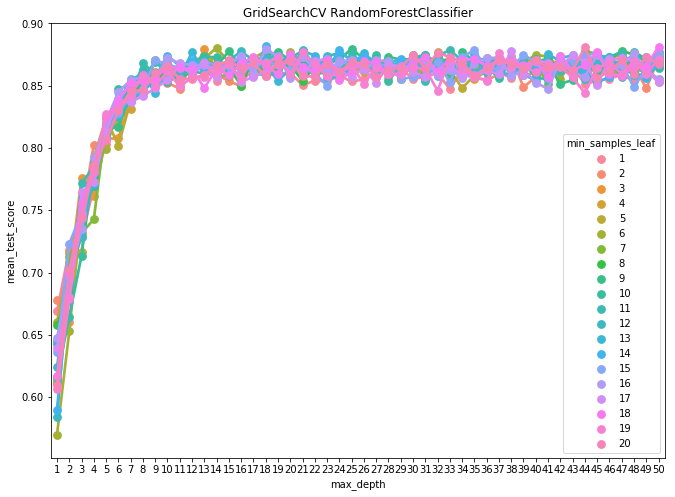

In [110]:
fig = plot_GridSearchCV_results(clf.cv_results_, 'max_depth', 'min_samples_leaf', 'RandomForestClassifier')

fig.savefig('Module3/GridSearchCV_' + 'RandomForestClassifier.png')

### Results

In [111]:
clf = RandomForestClassifier(n_estimators=100, max_depth=18, min_samples_leaf=14)
clf = clf.fit(X_train, y_train)

In [112]:
y_train_prediction = clf.predict(X_train)
y_test_prediction = clf.predict(X_test)

In [113]:
print('---- Train ----')
performance_metrics(y_train, y_train_prediction)

---- Train ----


,0,1,2
0,6266,4,0
1,0,6210,0
2,1,0,6209


                        Accuracy Score: 0.9997
                              F1-Score: 0.9997
Matthews Correlation Coefficient (MCC): 0.9996
            Area Under the Curve (AUC): 0.9996


In [114]:
print('---- Test ----')
performance_metrics(y_test, y_test_prediction)

---- Test ----


,0,1,2
0,2525,60,85
1,99,2438,43
2,222,116,2422


                        Accuracy Score: 0.9220
                              F1-Score: 0.9222
Matthews Correlation Coefficient (MCC): 0.8838
            Area Under the Curve (AUC): 0.8838


In [120]:
# save model

dump(clf, 'Module3/models/RandomForestClassifier.joblib')

['Module3/models/RandomForestClassifier.joblib']

## Plot Decision Boundary

In [56]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.datasets.base import load_iris
from sklearn.manifold.t_sne import TSNE
from sklearn.linear_model.logistic import LogisticRegression

stop_index = 4000

X_vis = X_train[0:stop_index, :]
y_viz = y_train[0:stop_index]
X_Train_embedded = TSNE(n_components=2).fit_transform(X_vis)
print(X_Train_embedded.shape)

(4000, 2)


In [71]:
m = 3

if m == 1:
    model = load('Module3/models/KNN.joblib')
elif m == 2:
    model = load('Module3/models/SVM.joblib')
elif m == 3:
    model = load('Module3/models/RandomForestClassifier.joblib')

print(model)

y_predicted = model.predict(X_vis)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Text(0.5,1,'RandomForestClassifier Voronoi Decision Boundary')

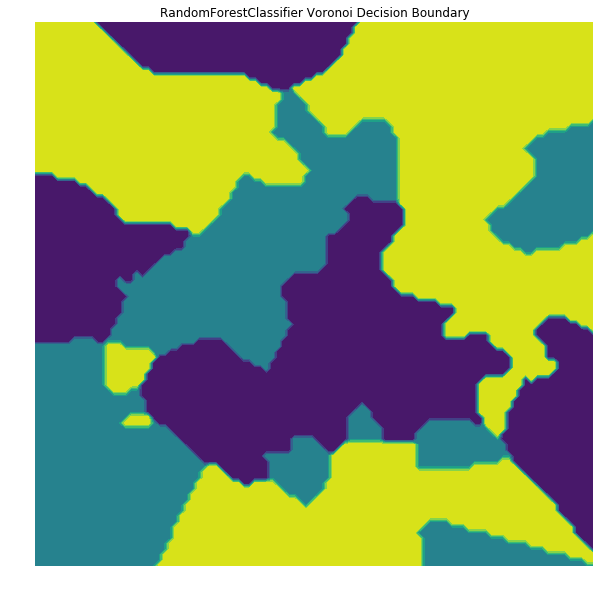

In [72]:
# create meshgrid
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:, 0]), np.max(X_Train_embedded[:, 0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:, 1]), np.max(X_Train_embedded[:, 1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
fig = plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, voronoiBackground)
plt.axis('off')
plt.title('RandomForestClassifier Voronoi Decision Boundary')
# plt.savefig('Module3/visual_' + 'RandomForestClassifier' + '.png')

# fig = plt.figure(figsize=(10, 10))
# plt.scatter(X_Train_embedded[:, 0], X_Train_embedded[:, 1], c=y_predicted)
# plt.show()